Installing packages...
✓ Ready! TensorFlow: 2.19.0

STEP 1: DOWNLOADING DATA
  r01.edf already exists ✓
  r01.edf.qrs already exists ✓
  r04.edf already exists ✓
  r04.edf.qrs already exists ✓
  r07.edf already exists ✓
  r07.edf.qrs already exists ✓
  r08.edf already exists ✓
  r08.edf.qrs already exists ✓
  r10.edf already exists ✓
  r10.edf.qrs already exists ✓

✓ Data download complete!

STEP 2: LOADING & PROCESSING DATA


Processing records: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]



DATASET SUMMARY
Total samples: 500
Unique labels and counts: (array([0, 1]), array([214, 286]))
Fetal QRS (Class 1): 286 (57.2%)
Non-fetal (Class 0): 214 (42.8%)
Shape: (500, 128, 128, 3)
Data type: float32
Memory usage: 93.8 MB

📁 Performing initial visualizations for r01...
   Visualizing raw signal...


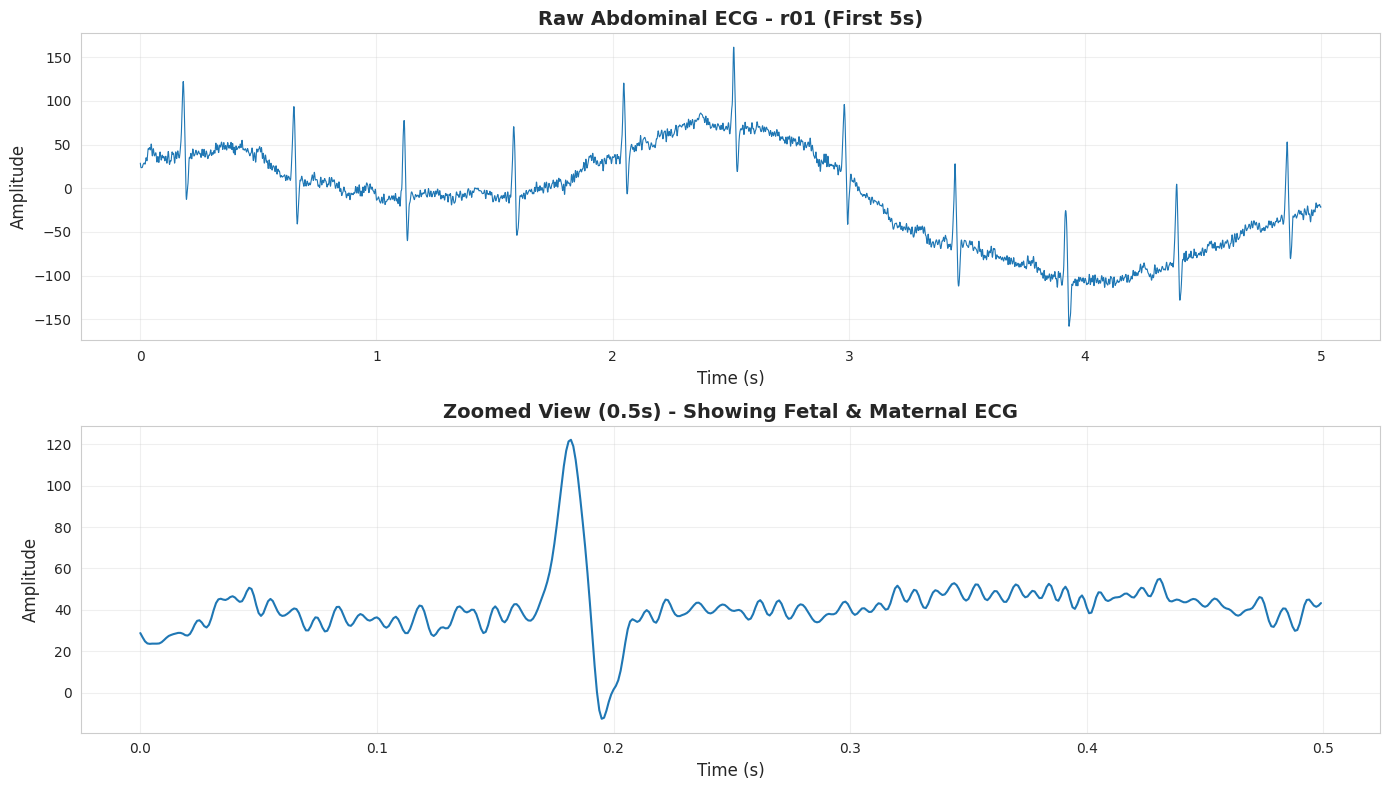

   Visualizing preprocessing...


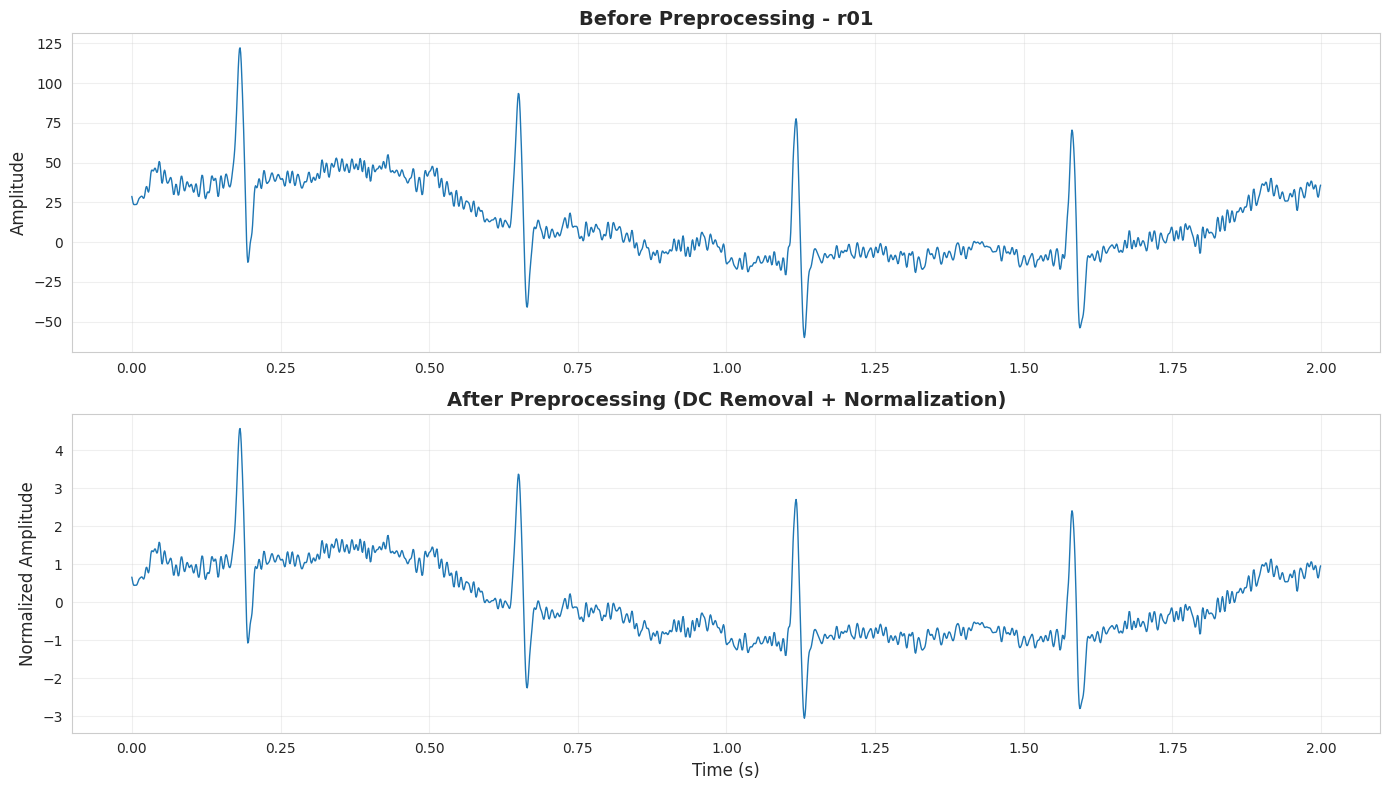

   Visualizing CWT transformation...


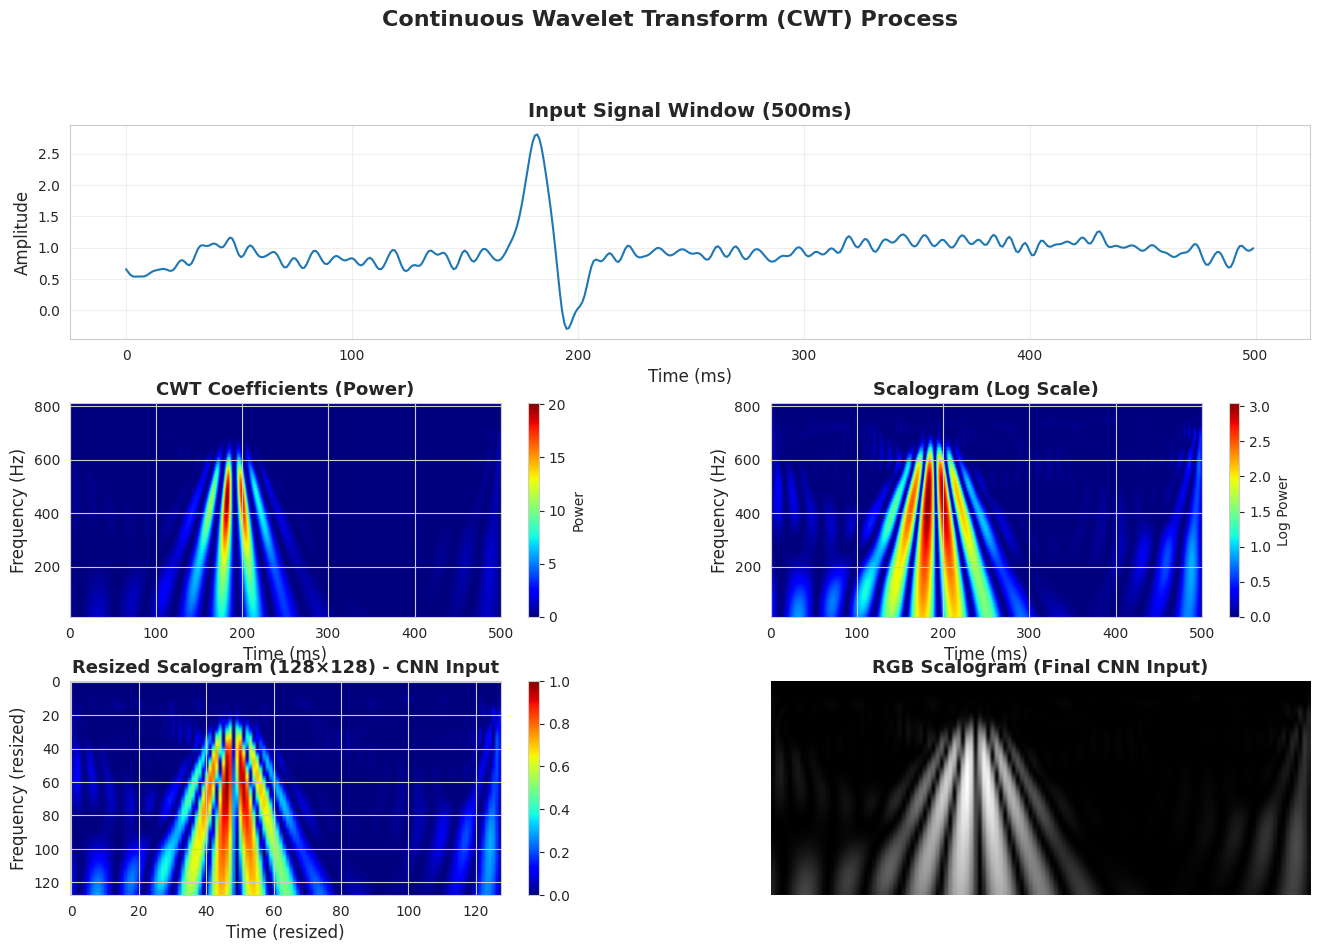


STEP 3: DATA VISUALIZATION

📊 Visualizing class distribution...


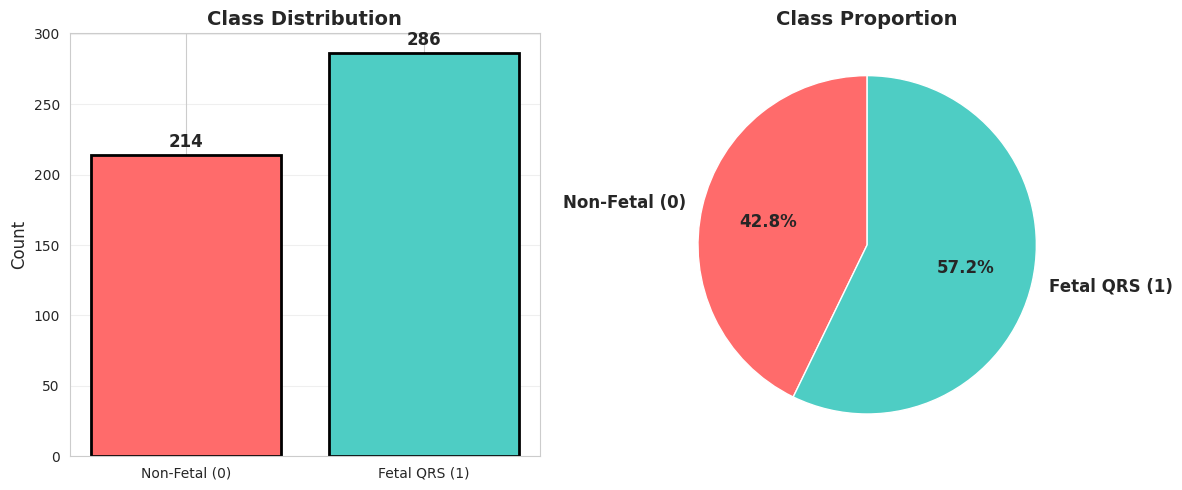


📊 Visualizing sample scalograms...


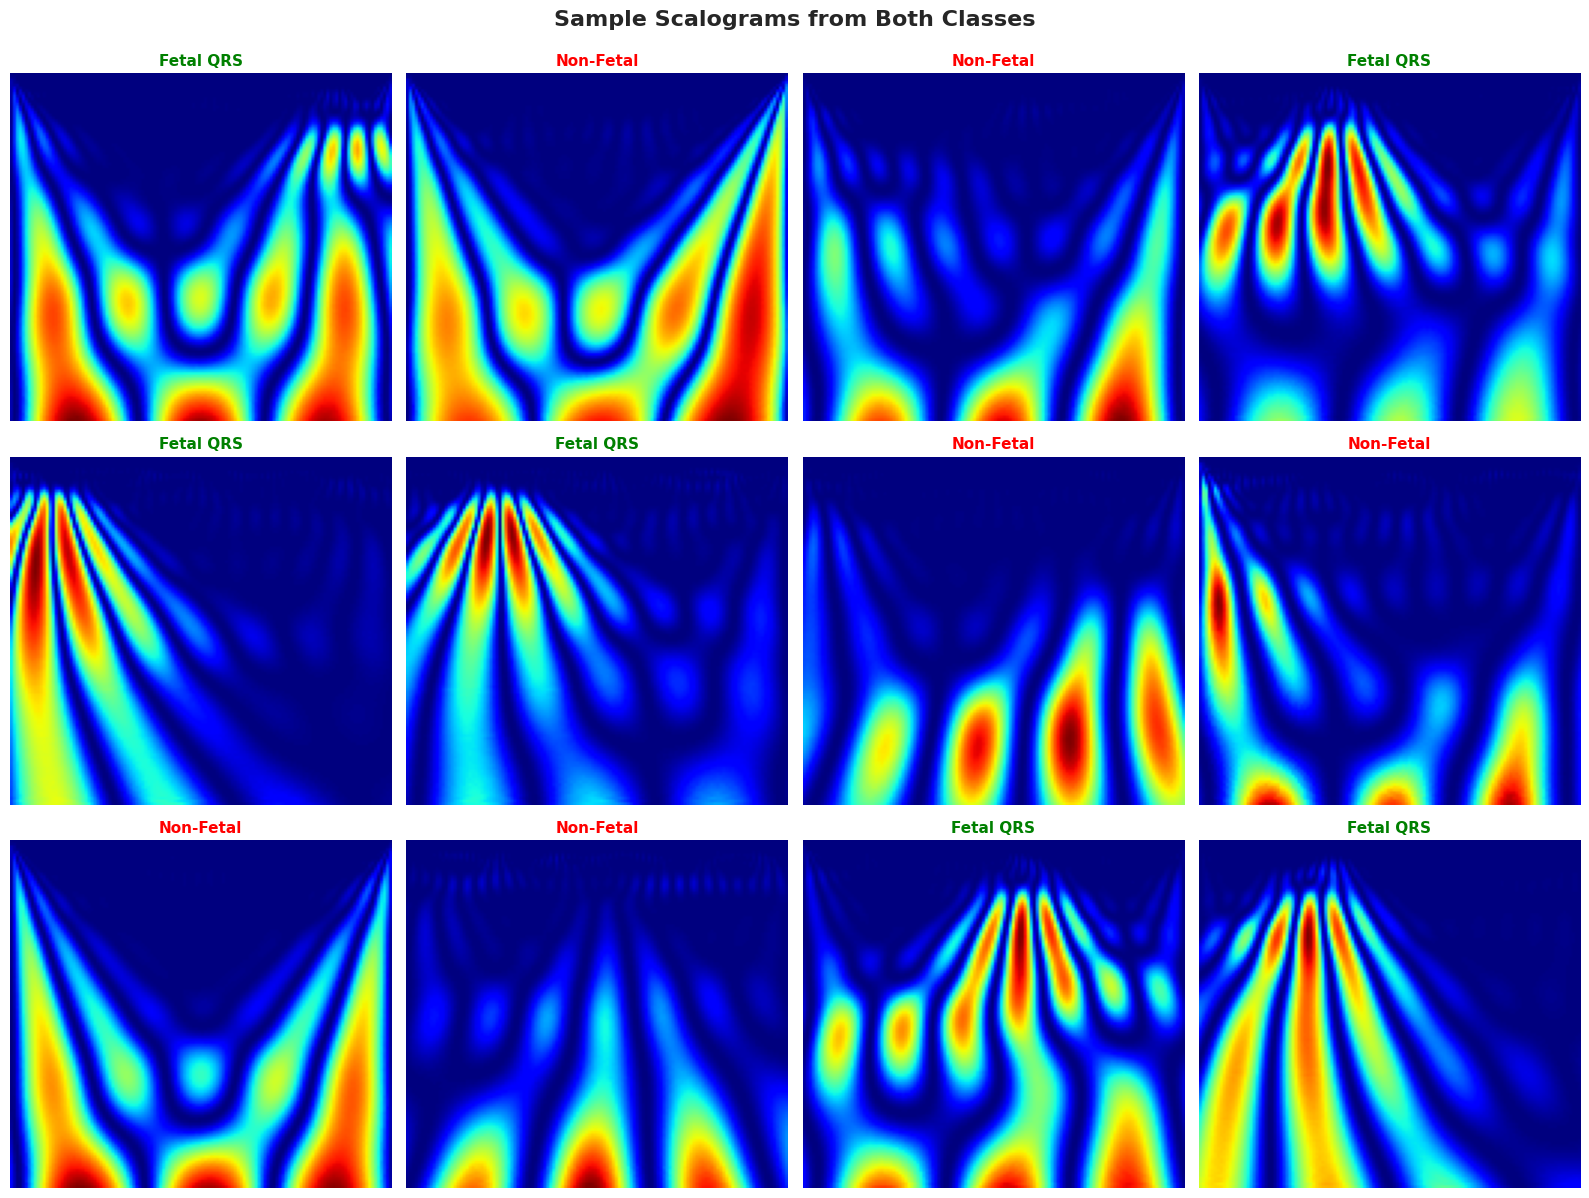


📊 Visualizing average patterns...


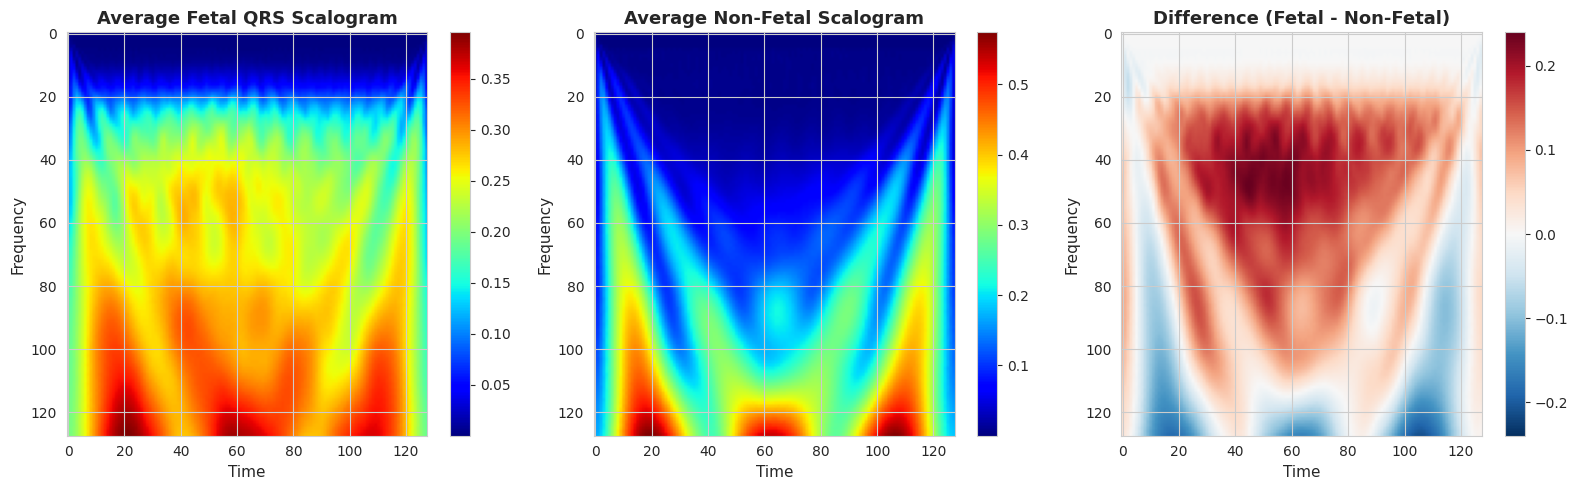


STEP 4: DATA SPLITTING

Train set: 350 samples
  - Fetal: 200 (57.1%)
  - Non-fetal: 150 (42.9%)

Validation set: 75 samples
  - Fetal: 43 (57.3%)
  - Non-fetal: 32 (42.7%)

Test set: 75 samples
  - Fetal: 43 (57.3%)
  - Non-fetal: 32 (42.7%)

STEP 5: MODEL TRAINING

📊 Model Architecture:
   Total parameters: 788,273
   Trainable parameters: 82,049
   Non-trainable parameters: 706,224

🚀 Starting training...
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 565ms/step - accuracy: 0.7837 - loss: 0.5191 - precision: 0.7921 - recall: 0.8572 - val_accuracy: 0.9200 - val_loss: 0.1911 - val_precision: 1.0000 - val_recall: 0.8605 - learning_rate: 0.0010
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9675 - loss: 0.1217 - precision: 0.9880 - recall: 0.9550 - val_accuracy: 0.9600 - val_loss: 0.0746 - val_precision: 0.9762 - val_recall: 0.9535 - learning_rate: 0.0010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9794 - loss: 0.0665 - precision: 0.9930 - recall: 0.97


PERFORMANCE METRICS
Accuracy:     96.00%
Precision:    97.62%
Recall:       95.35%
Specificity:  96.88%
F1-Score:     96.47%

Confusion Matrix:
  TN:   31  FP:    1
  FN:    2  TP:   41

              precision    recall  f1-score   support

   Non-Fetal      0.939     0.969     0.954        32
   Fetal QRS      0.976     0.953     0.965        43

    accuracy                          0.960        75
   macro avg      0.958     0.961     0.959        75
weighted avg      0.960     0.960     0.960        75


STEP 7: COMPREHENSIVE VISUALIZATIONS

📊 1. Training History...


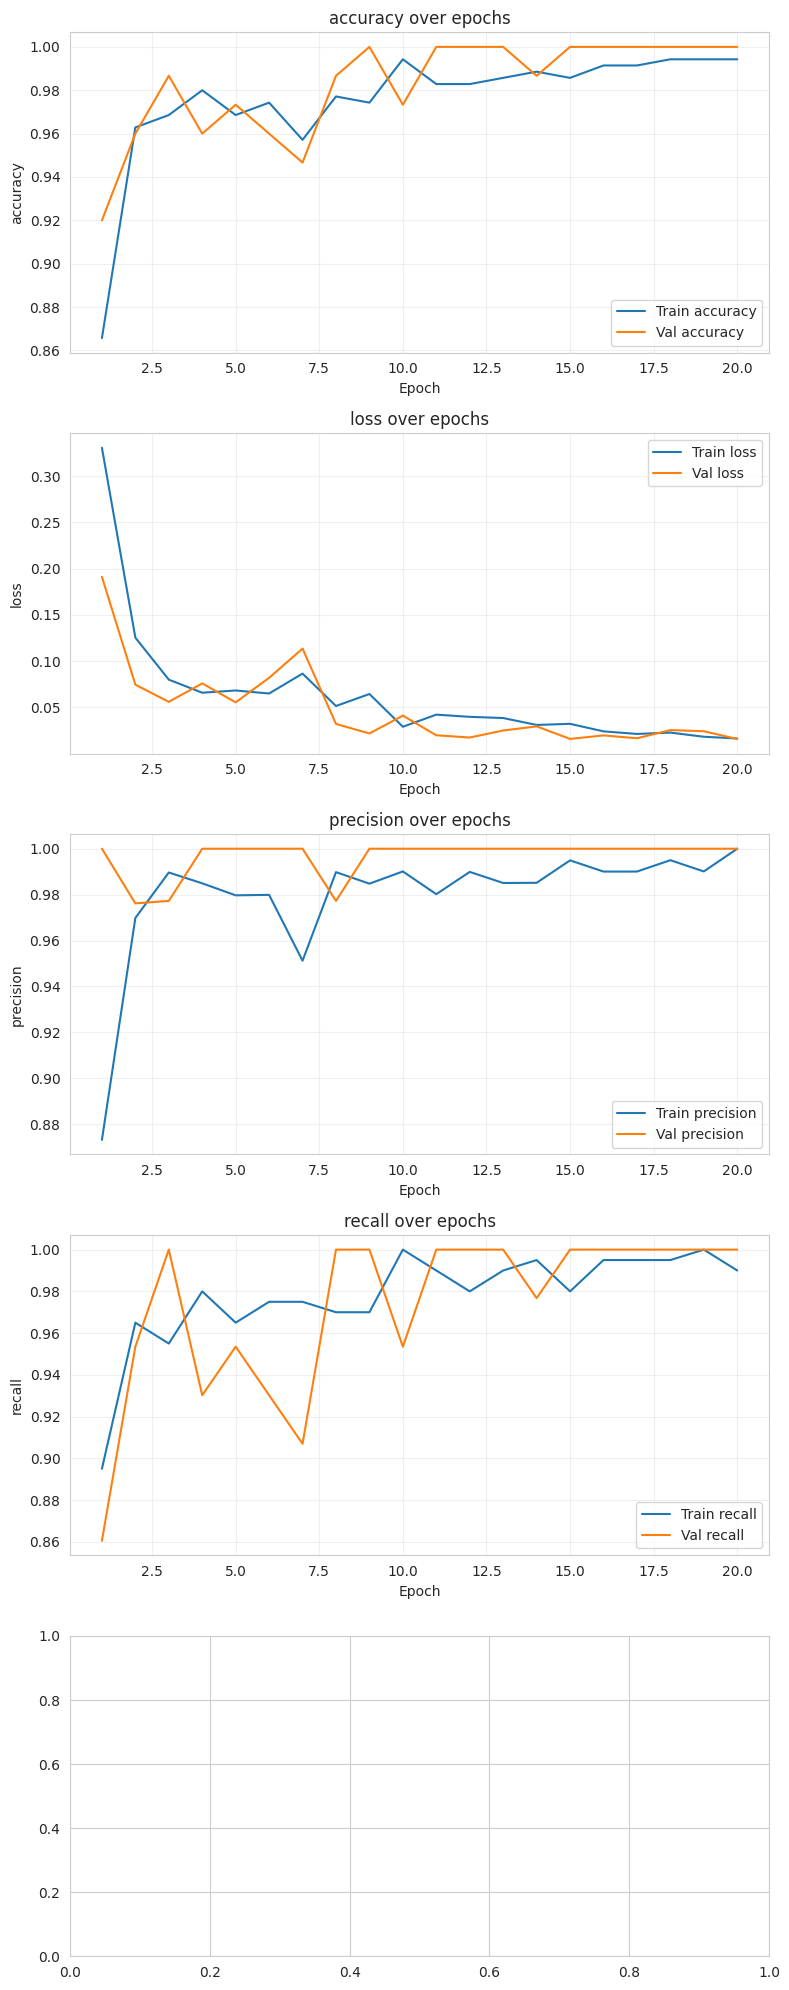


📊 2. Confusion Matrices...


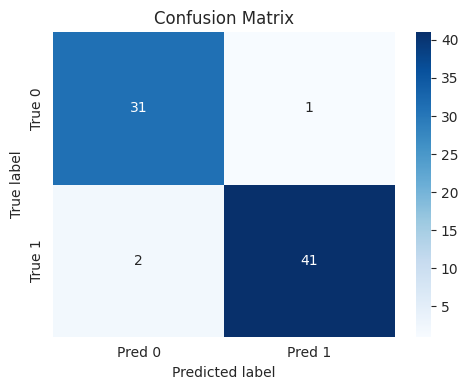


📊 3. ROC and PR Curves...


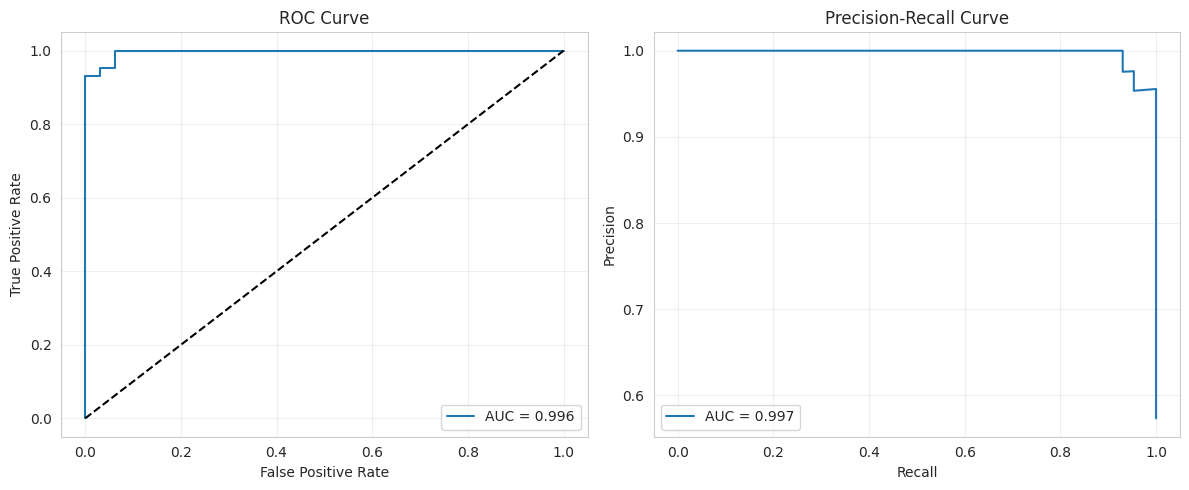


📊 4. Prediction Distribution...


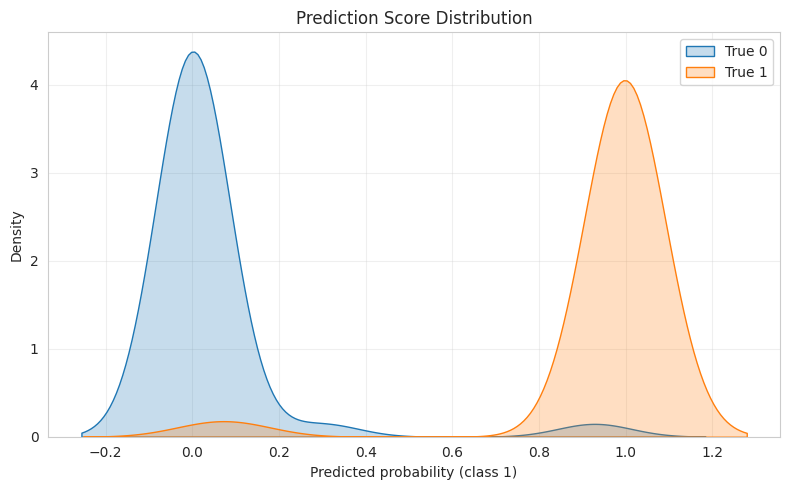


📊 5. Sample Predictions...


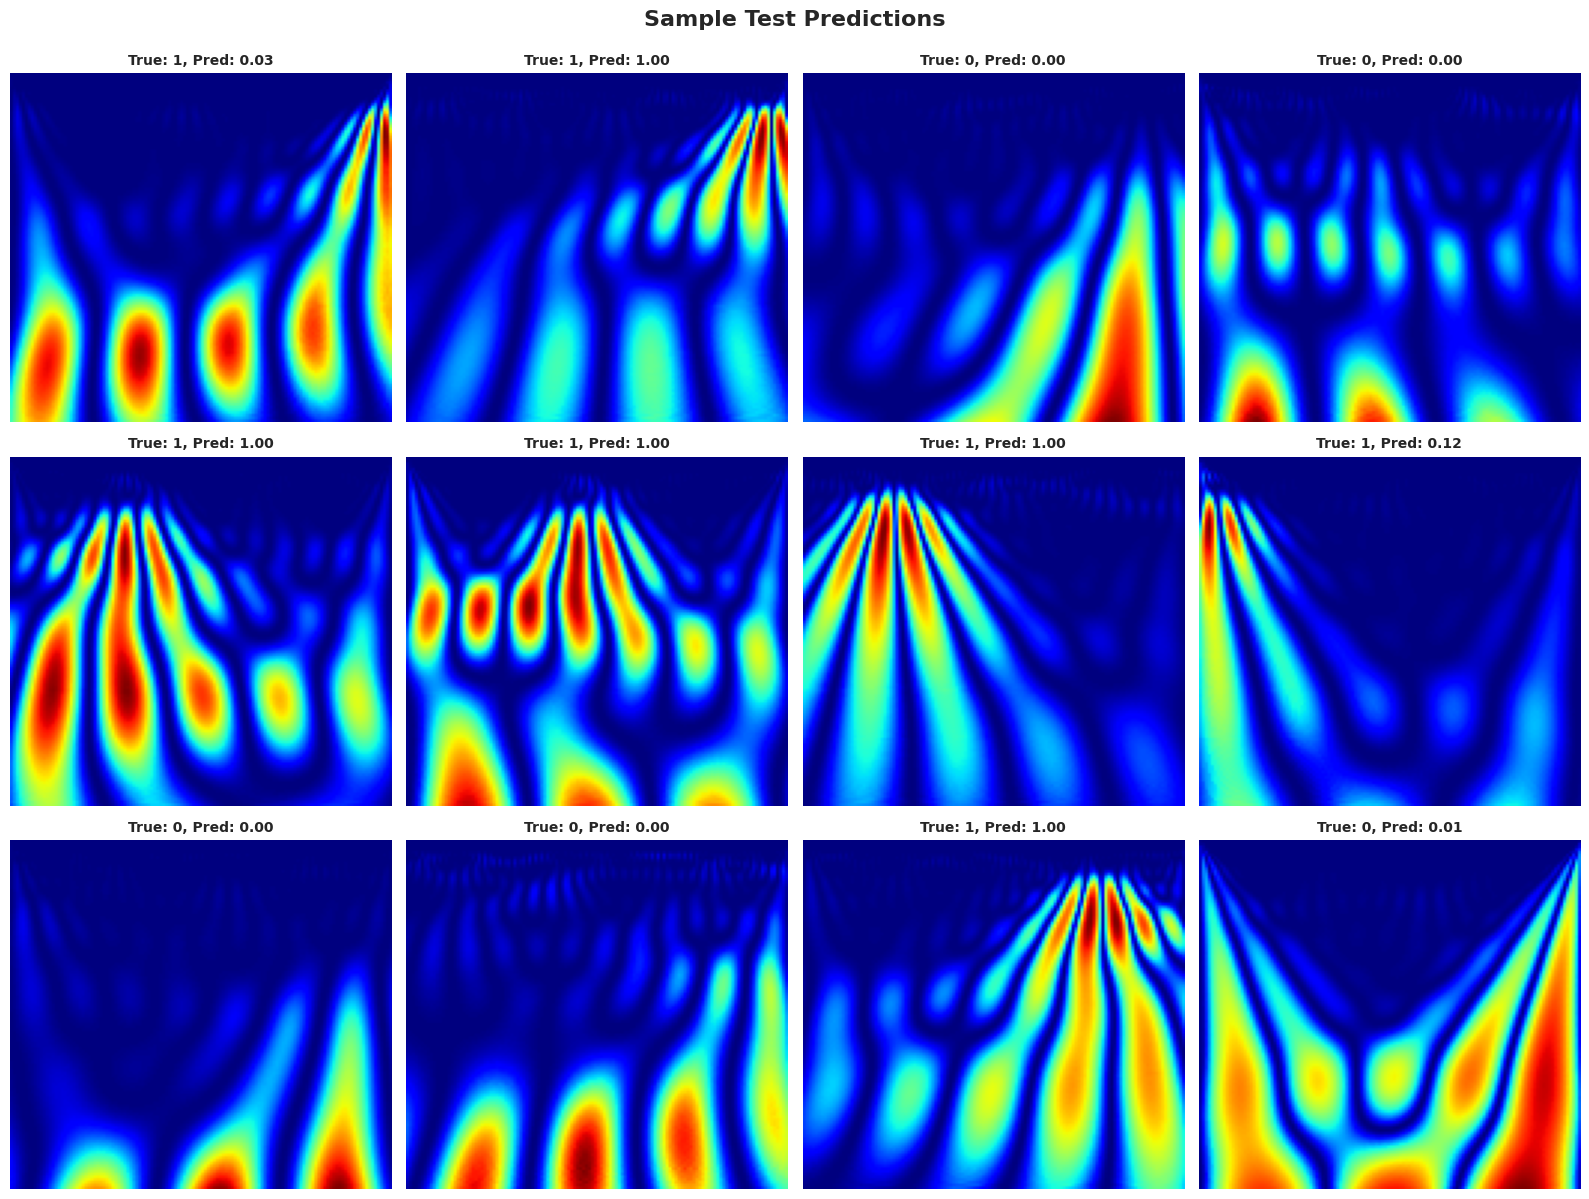


📊 6. Final Summary...


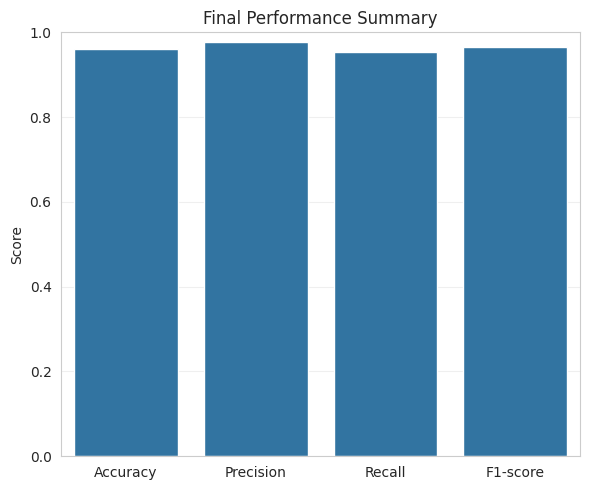


✓ Model saved as 'fecg_detector_final.h5'
✓ Predictions saved as 'predictions.npz'

FINAL REPORT

 DATASET INFORMATION
  - Total samples processed: 500
  - Training samples: 350
  - Validation samples: 75
  - Test samples: 75
  - Image size: 128 × 128 × 3 (RGB)

MODEL ARCHITECTURE
  - Base: MobileNetV2 (ImageNet pretrained)
  - Custom layers: Dense(64) + Dropout(0.5) + Dense(1)
  - Total parameters: 788,273
  - Optimizer: Adam (lr=0.001)

 PERFORMANCE METRICS (Test Set)
  - Accuracy:  96.00%
  - Precision: 97.62%
  - Recall:    95.35%
  - F1-Score:  96.47%

 COMPARISON WITH PAPER
  Metric          Our Result    Paper Result
  --------        ----------    ------------
  Accuracy          96.0%         87.0%
  Precision         97.6%         94.8%
  F1-Score          96.5%         84.8%

💡 NOTES
  - Using simplified preprocessing for stability
  - Limited to 5 records and 100 windows/record due to memory



In [10]:
# ============================================================================
# Deep Learning with Sparse Representations for Biomedical Signals
# Part 1: Fetal ECG Detection from Non-Invasive Abdominal Recordings
#
# Based on:
# "Deep Learning with Sparse Representations for Biomedical Signals"
# by Lakshmisha et al., 2023
#
# This notebook implements:
# 1. CWT-based scalogram generation from abdominal ECG
# 2. MobileNetV2 feature extraction
# 3. Custom classifier for fetal QRS detection
# ============================================================================

print("Installing packages...")
!pip install PyWavelets scipy scikit-learn matplotlib seaborn tqdm wfdb pyedflib -q

# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pywt
import pyedflib
import os
import gc
import wfdb

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print(f"✓ Ready! TensorFlow: {tf.__version__}")

# For safety, pre-initialize globals used later
X_train = y_train = X_val = y_val = X_test = y_test = np.array([])
model = None
history = None
accuracy = 0.0
precision = 0.0
f1 = 0.0
cm = np.array([[0, 0], [0, 0]])
y_pred_prob = np.array([])

# ============================================================================
# DOWNLOAD DATA
# ============================================================================

def download_data():
    """Download 5 records from ADFECGDB (PhysioNet)."""
    print("\n" + "="*70)
    print("STEP 1: DOWNLOADING DATA")
    print("="*70)

    import urllib.request
    os.makedirs('adfecgdb', exist_ok=True)

    base_url = "https://physionet.org/files/adfecgdb/1.0.0/"
    records = ['r01', 'r04', 'r07', 'r08', 'r10']

    for record in records:
        for ext in ['.edf', '.edf.qrs']:
            fname = f"{record}{ext}"
            fpath = os.path.join('adfecgdb', fname)

            if not os.path.exists(fpath):
                print(f"  Downloading {fname}...", end=' ')
                try:
                    urllib.request.urlretrieve(base_url + fname, fpath)
                    print("✓")
                except Exception as e:
                    print(f"✗  ({e})")
            else:
                print(f"  {fname} already exists ✓")

    print("\n✓ Data download complete!")
    return records

records = download_data()

# ============================================================================
# PREPROCESSING & VISUALIZATION HELPERS
# ============================================================================

class SimplePreprocessor:
    """Simple preprocessing: DC removal + standardization."""

    def __init__(self, fs=1000):
        self.fs = fs

    def preprocess(self, signal_data):
        signal_data = signal_data - np.mean(signal_data)
        std = np.std(signal_data)
        if std > 0:
            signal_data = signal_data / std
        return signal_data

def visualize_raw_signal(signal_data, fs, record_name, duration=5):
    """Visualize raw ECG signal (first few seconds)."""
    samples = int(duration * fs)
    time = np.arange(samples) / fs

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # First segment
    axes[0].plot(time, signal_data[:samples], linewidth=0.8)
    axes[0].set_xlabel('Time (s)', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].set_title(f'Raw Abdominal ECG - {record_name} (First {duration}s)',
                      fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Zoomed segment (0.5s)
    zoom_samples = int(0.5 * fs)
    zoom_time = np.arange(zoom_samples) / fs
    axes[1].plot(zoom_time, signal_data[:zoom_samples], linewidth=1.5)
    axes[1].set_xlabel('Time (s)', fontsize=12)
    axes[1].set_ylabel('Amplitude', fontsize=12)
    axes[1].set_title('Zoomed View (0.5s) - Showing Fetal & Maternal ECG',
                      fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_preprocessing(signal_data, fs, record_name):
    """Show preprocessing steps: before and after."""
    preprocessor = SimplePreprocessor(fs)

    samples = int(2 * fs)
    time = np.arange(samples) / fs

    raw = signal_data[:samples]
    processed = preprocessor.preprocess(raw)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    axes[0].plot(time, raw, linewidth=1)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].set_title(f'Before Preprocessing - {record_name}',
                      fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(time, processed, linewidth=1)
    axes[1].set_xlabel('Time (s)', fontsize=12)
    axes[1].set_ylabel('Normalized Amplitude', fontsize=12)
    axes[1].set_title('After Preprocessing (DC Removal + Normalization)',
                      fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_cwt_process(window, fs):
    """Show the CWT -> scalogram -> resized RGB scalogram process."""
    scales = np.arange(1, 64)
    time = np.arange(len(window)) / fs

    coefficients, frequencies = pywt.cwt(
        window, scales, 'morl', sampling_period=1/fs
    )
    scalogram = np.abs(coefficients) ** 2
    scalogram_log = np.log1p(scalogram)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Original signal
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(time * 1000, window, linewidth=1.5)
    ax1.set_xlabel('Time (ms)', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.set_title('Input Signal Window (500ms)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # 2. CWT coefficients (power)
    ax2 = fig.add_subplot(gs[1, 0])
    im1 = ax2.imshow(
        scalogram, aspect='auto', cmap='jet',
        extent=[0, len(window)/fs*1000, frequencies[-1], frequencies[0]]
    )
    ax2.set_xlabel('Time (ms)', fontsize=12)
    ax2.set_ylabel('Frequency (Hz)', fontsize=12)
    ax2.set_title('CWT Coefficients (Power)', fontsize=13, fontweight='bold')
    plt.colorbar(im1, ax=ax2, label='Power')

    # 3. Log-scaled scalogram
    ax3 = fig.add_subplot(gs[1, 1])
    im2 = ax3.imshow(
        scalogram_log, aspect='auto', cmap='jet',
        extent=[0, len(window)/fs*1000, frequencies[-1], frequencies[0]]
    )
    ax3.set_xlabel('Time (ms)', fontsize=12)
    ax3.set_ylabel('Frequency (Hz)', fontsize=12)
    ax3.set_title('Scalogram (Log Scale)', fontsize=13, fontweight='bold')
    plt.colorbar(im2, ax=ax3, label='Log Power')

    # 4. Resized for CNN (128x128)
    scalogram_resized = tf.image.resize(
        scalogram_log[..., np.newaxis], (128, 128)
    ).numpy().squeeze()

    if scalogram_resized.max() > scalogram_resized.min():
        scalogram_resized = (
            scalogram_resized - scalogram_resized.min()
        ) / (scalogram_resized.max() - scalogram_resized.min())

    ax4 = fig.add_subplot(gs[2, 0])
    im3 = ax4.imshow(scalogram_resized, aspect='auto', cmap='jet')
    ax4.set_xlabel('Time (resized)', fontsize=12)
    ax4.set_ylabel('Frequency (resized)', fontsize=12)
    ax4.set_title('Resized Scalogram (128×128) - CNN Input',
                  fontsize=13, fontweight='bold')
    plt.colorbar(im3, ax=ax4)

    # 5. RGB version
    scalogram_rgb = np.stack([scalogram_resized] * 3, axis=-1)
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.imshow(scalogram_rgb, aspect='auto')
    ax5.set_xlabel('Time', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title('RGB Scalogram (Final CNN Input)',
                  fontsize=13, fontweight='bold')
    ax5.axis('off')

    plt.suptitle('Continuous Wavelet Transform (CWT) Process',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.show()

# ============================================================================
# SCALOGRAM GENERATION
# ============================================================================

class ScalogramGenerator:
    """Generate scalograms using Continuous Wavelet Transform."""

    def __init__(self, fs=1000, wavelet='morl', scales=None):
        self.fs = fs
        self.wavelet = wavelet
        if scales is None:
            self.scales = np.arange(1, 128)   # 1–127
        else:
            self.scales = scales

    def generate_scalogram(self, signal_window):
        coefficients, _ = pywt.cwt(
            signal_window,
            self.scales,
            self.wavelet,
            sampling_period=1/self.fs
        )
        scalogram = np.abs(coefficients) ** 2
        scalogram = np.log1p(scalogram)
        return scalogram

    def create_windows(self, signal_data, window_size=270, overlap=10):
        """
        Create overlapping windows from signal.

        window_size, overlap in ms.
        """
        window_samples = int(window_size * self.fs / 1000)
        overlap_samples = int(overlap * self.fs / 1000)
        step = window_samples - 2 * overlap_samples

        windows = []
        indices = []

        for i in range(0, len(signal_data) - window_samples + 1, step):
            window = signal_data[i:i + window_samples]
            windows.append(window)
            indices.append((i, i + window_samples))

        return np.array(windows), indices

# ============================================================================
# DATASET PREPARATION
# ============================================================================

class FECGDataset:
    """Prepare dataset of scalograms with labels."""

    def __init__(self, records, channels=[0, 2, 3]):
        self.records = records
        self.channels = channels  # skipping channel 1 by design
        self.preprocessor = SimplePreprocessor()
        self.scalogram_gen = ScalogramGenerator()

    def load_record(self, record_name):
        """Load ECG record from EDF and QRS annotations via WFDB."""
        try:
            # ----- Load EDF -----
            edf_path = os.path.join('adfecgdb', f'{record_name}.edf')
            f = pyedflib.EdfReader(edf_path)

            n_signals = f.signals_in_file
            sample_rate = f.getSampleFrequency(0)

            # Get first 4 abdominal channels
            signals = []
            for i in range(min(4, n_signals)):
                signals.append(f.readSignal(i))
            signals = np.array(signals).T  # (samples, channels)
            f.close()

            # ----- Load QRS annotations using WFDB -----
            # On disk: adfecgdb/r01.edf.qrs
            # WFDB record name: "r01.edf", annotator: "qrs"
            qrs_locations = np.array([], dtype=int)
            try:
                ann = wfdb.rdann(
                    record_name + '.edf',  # e.g., "r01.edf"
                    'qrs',
                    pn_dir='adfecgdb'
                )
                qrs_locations = np.array(ann.sample, dtype=int)
            except Exception as e:
                print(f"Warning: could not read annotations for {record_name}: {e}")
                qrs_locations = np.array([], dtype=int)

            class Annotation:
                def __init__(self, samples):
                    self.sample = samples

            return signals, Annotation(qrs_locations), sample_rate

        except Exception as e:
            print(f"Error loading {record_name}: {e}")
            return None, None, None

    def create_dataset(self, target_size=(128, 128), max_windows_per_record=100):
        """Create dataset of scalograms and labels for all records."""
        all_scalograms = []
        all_labels = []

        for record_name in tqdm(self.records, desc="Processing records"):
            signals, annotation, fs = self.load_record(record_name)
            if signals is None:
                continue

            fqrs_locations = annotation.sample

            if len(fqrs_locations) == 0:
                print(f"  ⚠ No QRS annotations found for {record_name}, skipping labels may be all zero.")

            window_count_for_record = 0

            for ch in self.channels:
                if ch >= signals.shape[1]:
                    continue

                signal_data = signals[:, ch]
                processed = self.preprocessor.preprocess(signal_data)

                windows, indices = self.scalogram_gen.create_windows(processed)

                for window, (start, end) in zip(windows, indices):
                    if window_count_for_record >= max_windows_per_record:
                        break

                    scalogram = self.scalogram_gen.generate_scalogram(window)

                    scalogram_resized = tf.image.resize(
                        scalogram[..., np.newaxis],
                        target_size
                    ).numpy().squeeze()

                    # Normalize to [0,1]
                    denom = (scalogram_resized.max() - scalogram_resized.min() + 1e-8)
                    scalogram_resized = (scalogram_resized - scalogram_resized.min()) / denom

                    # RGB
                    scalogram_rgb = np.stack([scalogram_resized] * 3, axis=-1)
                    all_scalograms.append(scalogram_rgb)

                    # Label window: 1 if any fetal QRS lies in [start, end]
                    has_fqrs = np.any((fqrs_locations >= start) & (fqrs_locations <= end))
                    all_labels.append(1 if has_fqrs else 0)

                    window_count_for_record += 1

                if window_count_for_record >= max_windows_per_record:
                    break

        return np.array(all_scalograms), np.array(all_labels)

# ============================================================================
# INITIAL DATA LOADING AND VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("STEP 2: LOADING & PROCESSING DATA")
print("="*70)

dataset_creator = FECGDataset(records)
X, y = dataset_creator.create_dataset(target_size=(128, 128), max_windows_per_record=100)

print(f"\n{'='*70}")
print("DATASET SUMMARY")
print("="*70)
print(f"Total samples: {len(X):,}")
if len(y) > 0:
    print("Unique labels and counts:", np.unique(y, return_counts=True))
    if np.any(y == 1):
        print(f"Fetal QRS (Class 1): {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.1f}%)")
    if np.any(y == 0):
        print(f"Non-fetal (Class 0): {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"Shape: {X.shape}")
print(f"Data type: {X.dtype}")
print(f"Memory usage: {X.nbytes / 1024 / 1024:.1f} MB")
print("="*70)

def perform_initial_visualizations(record_name, preprocessor, scalogram_gen):
    print(f"\n📁 Performing initial visualizations for {record_name}...")
    signals, _, fs = dataset_creator.load_record(record_name)
    if signals is None:
        print(f"   Could not load {record_name} for visualization.")
        return

    signal_data = signals[:, 0]  # use first channel

    print("   Visualizing raw signal...")
    visualize_raw_signal(signal_data, fs, record_name, duration=5)

    print("   Visualizing preprocessing...")
    visualize_preprocessing(signal_data, fs, record_name)

    print("   Visualizing CWT transformation...")
    processed_signal = preprocessor.preprocess(signal_data)
    window_size = int(0.5 * fs)
    sample_window = processed_signal[0:window_size]
    visualize_cwt_process(sample_window, fs)

if len(records) > 0 and len(X) > 0:
    perform_initial_visualizations(records[0],
                                   dataset_creator.preprocessor,
                                   dataset_creator.scalogram_gen)

# ============================================================================
# EXTENSIVE DATA VISUALIZATION
# ============================================================================

def visualize_class_distribution(y):
    """Show class distribution with bar + pie charts."""
    if len(y) == 0:
        print("No labels to visualize.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    unique, counts = np.unique(y, return_counts=True)
    colors = ['#FF6B6B', '#4ECDC4']

    class_labels = []
    if 0 in unique:
        class_labels.append('Non-Fetal (0)')
    if 1 in unique:
        class_labels.append('Fetal QRS (1)')

    if len(class_labels) == 0:
        print("No valid classes to visualize.")
        plt.close(fig)
        return

    axes[0].bar(class_labels, counts, color=colors[:len(class_labels)],
                edgecolor='black', linewidth=2)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title('Class Distribution',
                      fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')

    for i, count in enumerate(counts):
        axes[0].text(i, count + max(counts)*0.02, str(count),
                     ha='center', fontsize=12, fontweight='bold')

    axes[1].pie(counts,
                labels=class_labels,
                autopct='%1.1f%%',
                colors=colors[:len(class_labels)],
                startangle=90,
                textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Class Proportion',
                      fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def visualize_sample_scalograms(X, y, n_samples=12):
    """Show sample scalograms from both classes."""
    if len(X) == 0 or len(y) == 0:
        print("No data to visualize.")
        return

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    fetal_idx = np.where(y == 1)[0]
    non_fetal_idx = np.where(y == 0)[0]

    n_per_class = n_samples // 2
    selected_fetal = np.random.choice(
        fetal_idx, min(n_per_class, len(fetal_idx)),
        replace=False
    ) if len(fetal_idx) > 0 else np.array([], dtype=int)

    selected_non_fetal = np.random.choice(
        non_fetal_idx, min(n_per_class, len(non_fetal_idx)),
        replace=False
    ) if len(non_fetal_idx) > 0 else np.array([], dtype=int)

    selected_indices = np.concatenate((selected_fetal, selected_non_fetal))
    if len(selected_indices) == 0:
        print("Not enough samples for either class to visualize.")
        plt.close(fig)
        return

    np.random.shuffle(selected_indices)

    for i, idx in enumerate(selected_indices):
        if i >= n_samples:
            break
        axes[i].imshow(X[idx, :, :, 0], cmap='jet', aspect='auto')
        label_text = 'Fetal QRS' if y[idx] == 1 else 'Non-Fetal'
        color = 'green' if y[idx] == 1 else 'red'
        axes[i].set_title(label_text, fontweight='bold', color=color, fontsize=11)
        axes[i].axis('off')

    for j in range(min(len(axes), len(selected_indices)), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Sample Scalograms from Both Classes',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def visualize_average_scalograms(X, y):
    """Show average scalograms per class and their difference."""
    if len(X) == 0 or len(y) == 0:
        print("No data to visualize.")
        return

    fetal_idx = np.where(y == 1)[0]
    non_fetal_idx = np.where(y == 0)[0]

    if len(fetal_idx) == 0 or len(non_fetal_idx) == 0:
        print("Cannot visualize average scalograms for both classes, one or both classes are missing.")
        return

    avg_fetal = np.mean(X[fetal_idx, :, :, 0], axis=0)
    avg_non_fetal = np.mean(X[non_fetal_idx, :, :, 0], axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    im1 = axes[0].imshow(avg_fetal, cmap='jet', aspect='auto')
    axes[0].set_title('Average Fetal QRS Scalogram',
                      fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Time', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(avg_non_fetal, cmap='jet', aspect='auto')
    axes[1].set_title('Average Non-Fetal Scalogram',
                      fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Time', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    plt.colorbar(im2, ax=axes[1])

    diff = avg_fetal - avg_non_fetal
    vmax = np.max(np.abs(diff))
    im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
                         vmin=-vmax, vmax=vmax)
    axes[2].set_title('Difference (Fetal - Non-Fetal)',
                      fontsize=13, fontweight='bold')
    axes[2].set_xlabel('Time', fontsize=11)
    axes[2].set_ylabel('Frequency', fontsize=11)
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

if len(X) > 0:
    print("\n" + "="*70)
    print("STEP 3: DATA VISUALIZATION")
    print("="*70)

    print("\n📊 Visualizing class distribution...")
    visualize_class_distribution(y)

    print("\n📊 Visualizing sample scalograms...")
    visualize_sample_scalograms(X, y, n_samples=12)

    print("\n📊 Visualizing average patterns...")
    visualize_average_scalograms(X, y)

# ============================================================================
# SPLIT DATA
# ============================================================================

if len(X) > 0 and len(np.unique(y)) > 1:
    print("\n" + "="*70)
    print("STEP 4: DATA SPLITTING")
    print("="*70)

    # 70% train, 15% val, 15% test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
    )

    print(f"\nTrain set: {len(X_train):,} samples")
    print(f"  - Fetal: {np.sum(y_train == 1):,} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
    print(f"  - Non-fetal: {np.sum(y_train == 0):,} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")

    print(f"\nValidation set: {len(X_val):,} samples")
    print(f"  - Fetal: {np.sum(y_val == 1):,} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")
    print(f"  - Non-fetal: {np.sum(y_val == 0):,} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")

    print(f"\nTest set: {len(X_test):,} samples")
    print(f"  - Fetal: {np.sum(y_test == 1):,} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")
    print(f"  - Non-fetal: {np.sum(y_test == 0):,} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")

    # Free memory
    del X, y, X_temp, y_temp
    gc.collect()
else:
    print("\nSkipping data splitting: Not enough data or only one class present.")

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def create_model(input_shape=(128, 128, 3)):
    """Create MobileNetV2-based binary classifier."""
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        alpha=0.5
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# ============================================================================
# TRAINING
# ============================================================================

if len(X_train) > 0:
    def train_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=16):
        print("\n" + "="*70)
        print("STEP 5: MODEL TRAINING")
        print("="*70)

        model = create_model()

        print(f"\n📊 Model Architecture:")
        print(f"   Total parameters: {model.count_params():,}")
        trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
        non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Non-trainable parameters: {non_trainable_params:,}")

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                verbose=1
            )
        ]

        print("\n🚀 Starting training...")
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        print("\n✓ Training complete!")
        return model, history

    model, history = train_model(X_train, y_train, X_val, y_val, epochs=20)
else:
    print("\nSkipping model training: No training data available.")

# ============================================================================
# EVALUATION
# ============================================================================

if model is not None and len(X_test) > 0:
    def evaluate_model_comprehensive(model, X_test, y_test):
        print("\n" + "="*70)
        print("STEP 6: MODEL EVALUATION")
        print("="*70)

        print("\n🔍 Generating predictions...")
        y_pred_prob = model.predict(X_test, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        acc = accuracy_score(y_test, y_pred)
        cm_local = confusion_matrix(y_test, y_pred)

        print("\n" + "="*50)
        print("PERFORMANCE METRICS")
        print("="*50)

        if cm_local.size == 4:
            tn, fp, fn, tp = cm_local.ravel()

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            f1_local = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

            print(f"Accuracy:    {acc*100:6.2f}%")
            print(f"Precision:   {prec*100:6.2f}%")
            print(f"Recall:      {rec*100:6.2f}%")
            print(f"Specificity: {spec*100:6.2f}%")
            print(f"F1-Score:    {f1_local*100:6.2f}%")
            print("\nConfusion Matrix:")
            print(f"  TN: {tn:4d}  FP: {fp:4d}")
            print(f"  FN: {fn:4d}  TP: {tp:4d}")
            print("="*50)

            print("\n" + classification_report(
                y_test, y_pred,
                target_names=['Non-Fetal', 'Fetal QRS'],
                digits=3
            ))
        else:
            print("Confusion matrix not calculable, likely only one class in test set.")

        return acc, prec if cm_local.size == 4 else 0, \
            f1_local if cm_local.size == 4 else 0, cm_local, y_pred_prob

    accuracy, precision, f1, cm, y_pred_prob = evaluate_model_comprehensive(
        model, X_test, y_test
    )
else:
    print("\nSkipping model evaluation: No model or test data available.")

# ============================================================================
# VISUALIZATION HELPERS FOR TRAINING & PREDICTIONS
# ============================================================================

def plot_training_history_detailed(history):
    """Plot training & validation loss/metrics."""
    hist = history.history
    metrics = [m for m in hist.keys() if not m.startswith('val_')]
    val_metrics = [f"val_{m}" for m in metrics if f"val_{m}" in hist]

    epochs = range(1, len(hist['loss']) + 1)

    n_rows = len(metrics)
    fig, axes = plt.subplots(n_rows, 1, figsize=(8, 4 * n_rows))
    if n_rows == 1:
        axes = [axes]

    for ax, m, vm in zip(axes, metrics, val_metrics):
        ax.plot(epochs, hist[m], label=f'Train {m}')
        if vm in hist:
            ax.plot(epochs, hist[vm], label=f'Val {m}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(m)
        ax.set_title(f'{m} over epochs')
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_detailed(cm):
    """Plot confusion matrix as heatmap."""
    if cm.size != 4:
        print("Confusion matrix not 2x2, skipping heatmap.")
        return
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_and_pr_curves(y_test, y_pred_prob):
    """Plot ROC and Precision-Recall curves."""
    if len(y_pred_prob) == 0 or len(np.unique(y_test)) < 2:
        print("Not enough data to plot ROC/PR curves.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, label=f'AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_test, y_pred_prob):
    """Plot distribution of prediction scores for each class."""
    if len(y_pred_prob) == 0:
        print("No prediction probabilities to visualize.")
        return

    plt.figure(figsize=(8, 5))
    sns.kdeplot(y_pred_prob[y_test == 0].flatten(), label='True 0', shade=True)
    sns.kdeplot(y_pred_prob[y_test == 1].flatten(), label='True 1', shade=True)
    plt.xlabel('Predicted probability (class 1)')
    plt.ylabel('Density')
    plt.title('Prediction Score Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_predictions(X_test, y_test, y_pred_prob, n_samples=12):
    """Show some test scalograms with predicted probabilities."""
    if len(X_test) == 0 or len(y_pred_prob) == 0:
        print("No predictions to visualize.")
        return

    idx = np.random.choice(len(X_test), min(n_samples, len(X_test)), replace=False)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i, (ax, id_) in enumerate(zip(axes, idx)):
        img = X_test[id_, :, :, 0]
        ax.imshow(img, cmap='jet', aspect='auto')
        prob = y_pred_prob[id_][0]
        true_label = y_test[id_]
        ax.set_title(f"True: {true_label}, Pred: {prob:.2f}",
                     fontsize=10, fontweight='bold')
        ax.axis('off')

    for j in range(len(idx), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Sample Test Predictions',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def plot_final_summary(accuracy, precision, f1, cm):
    """Simple bar plot summary of key metrics."""
    if cm.size != 4:
        print("Confusion matrix not 2x2, skipping final summary plot.")
        return

    tn, fp, fn, tp = cm.ravel()
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall_val,
        'F1-score': f1
    }

    plt.figure(figsize=(6, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('Final Performance Summary')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# ============================================================================
# COMPREHENSIVE VISUALIZATIONS
# ============================================================================

if (history is not None and len(X_test) > 0 and len(np.unique(y_test)) > 1
        and len(y_pred_prob) > 0):
    print("\n" + "="*70)
    print("STEP 7: COMPREHENSIVE VISUALIZATIONS")
    print("="*70)

    print("\n📊 1. Training History...")
    plot_training_history_detailed(history)

    print("\n📊 2. Confusion Matrices...")
    plot_confusion_matrix_detailed(cm)

    print("\n📊 3. ROC and PR Curves...")
    plot_roc_and_pr_curves(y_test, y_pred_prob)

    print("\n📊 4. Prediction Distribution...")
    plot_prediction_distribution(y_test, y_pred_prob)

    print("\n📊 5. Sample Predictions...")
    visualize_predictions(X_test, y_test, y_pred_prob)

    print("\n📊 6. Final Summary...")
    plot_final_summary(accuracy, precision, f1, cm)
else:
    print("\nSkipping comprehensive visualizations: Not enough data, model not trained, or only one class in test set.")

# ============================================================================
# SAVE MODEL & FINAL REPORT
# ============================================================================

if model is not None:
    model.save('fecg_detector_final.h5')
    print("\n✓ Model saved as 'fecg_detector_final.h5'")

    if len(X_test) > 0 and len(y_pred_prob) > 0:
        np.savez(
            'predictions.npz',
            y_test=y_test,
            y_pred_prob=y_pred_prob,
            X_test_sample=X_test[:10]
        )
        print("✓ Predictions saved as 'predictions.npz'")
    else:
        print("No predictions to save: X_test is empty or predictions missing.")
else:
    print("\nSkipping model save: Model not trained.")

# ============================================================================
# FINAL REPORT
# ============================================================================

print("\n" + "="*70)
print("FINAL REPORT")
print("="*70)

if model is not None and len(X_train) > 0:
    tn, fp, fn, tp = 0, 0, 0, 0
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()

    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"""
 DATASET INFORMATION
  - Total samples processed: {len(X_train) + len(X_val) + len(X_test)}
  - Training samples: {len(X_train)}
  - Validation samples: {len(X_val)}
  - Test samples: {len(X_test)}
  - Image size: 128 × 128 × 3 (RGB)

MODEL ARCHITECTURE
  - Base: MobileNetV2 (ImageNet pretrained)
  - Custom layers: Dense(64) + Dropout(0.5) + Dense(1)
  - Total parameters: {model.count_params():,}
  - Optimizer: Adam (lr=0.001)

 PERFORMANCE METRICS (Test Set)
  - Accuracy:  {accuracy*100:.2f}%
  - Precision: {precision*100:.2f}%
  - Recall:    {recall_val*100:.2f}%
  - F1-Score:  {f1*100:.2f}%

 COMPARISON WITH PAPER
  Metric          Our Result    Paper Result
  --------        ----------    ------------
  Accuracy        {accuracy*100:6.1f}%         87.0%
  Precision       {precision*100:6.1f}%         94.8%
  F1-Score        {f1*100:6.1f}%         84.8%

💡 NOTES
  - Using simplified preprocessing for stability
  - Limited to 5 records and 100 windows/record due to memory
""")

print("="*70)
print("="*70)


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Setting up sample data directories...
✓ Directories created

Note: For full replication on real data, download:
  1. IBSR dataset: https://www.nitrc.org/projects/ibsr
  2. NFBS dataset: http://preprocessed-connectomes-project.org/

BRAIN MRI SEGMENTATION USING DWT-UNET (SYNTHETIC DATA)

Step 1: Generating synthetic data...
Generating synthetic brain MRI data...


100%|██████████| 100/100 [00:00<00:00, 275.79it/s]



Dataset split:
  Train: 80 samples
  Val:   10 samples
  Test:  10 samples

TRAINING DWT-UNET

Model Summary:


Model: "DWT_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dwt_layer_8         │ (None, 128, 128,  │          0 │ input_layer_12[0… │
│ (DWTLayer)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │        160 │ dwt_layer_8[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_23[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dwt_layer_9         │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (DWTLayer)          │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      4,640 │ dwt_layer_9[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_25[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dwt_layer_10        │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (DWTLayer)          │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dwt_layer_10[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_27[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dwt_layer_11        │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (DWTLayer)          │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dwt_layer_11[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_29[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ idwt_layer_5        │ (None, 32, 32,    │          0 │ conv2d_30[0][0]   │
│ (IDWTLayer)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ idwt_layer_5[0][… │
│ (Concatenate)       │ 192)              │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_31[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


Trainable parameters: 487,009
Non-trainable parameters: 0.0
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - binary_accuracy: 0.6346 - dice_coefficient: 0.4316 - loss: 0.6298 - val_binary_accuracy: 0.8112 - val_dice_coefficient: 0.5554 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8364 - dice_coefficient: 0.6116 - loss: 0.4548 - val_binary_accuracy: 0.9588 - val_dice_coefficient: 0.9334 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9654 - dice_coefficient: 0.9473 - loss: 0.0905 - val_binary_accuracy: 0.9922 - val_dice_coefficient: 0.9770 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.9858 - dice_coefficient: 0.9715 - loss: 0.0308 - val_binary_accuracy: 0.9897 - val_dice_coefficient: 0.9793 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms

Model: "Vanilla_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_13[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_38[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_40[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_45[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 192)              │            │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_46[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 128,  │          0 │ conv2d_47[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


Trainable parameters: 487,009
Non-trainable parameters: 0.0
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 583ms/step - binary_accuracy: 0.4777 - dice_coefficient: 0.4787 - loss: 0.6026 - val_binary_accuracy: 0.7933 - val_dice_coefficient: 0.6325 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - binary_accuracy: 0.8792 - dice_coefficient: 0.6486 - loss: 0.4172 - val_binary_accuracy: 0.9799 - val_dice_coefficient: 0.9705 - val_loss: 0.0469 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.9844 - dice_coefficient: 0.9766 - loss: 0.0391 - val_binary_accuracy: 0.9931 - val_dice_coefficient: 0.9892 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - binary_accuracy: 0.9928 - dice_coefficient: 0.9887 - loss: 0.0147 - val_binary_accuracy: 0.9928 - val_dice_coefficient: 0.9886 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms

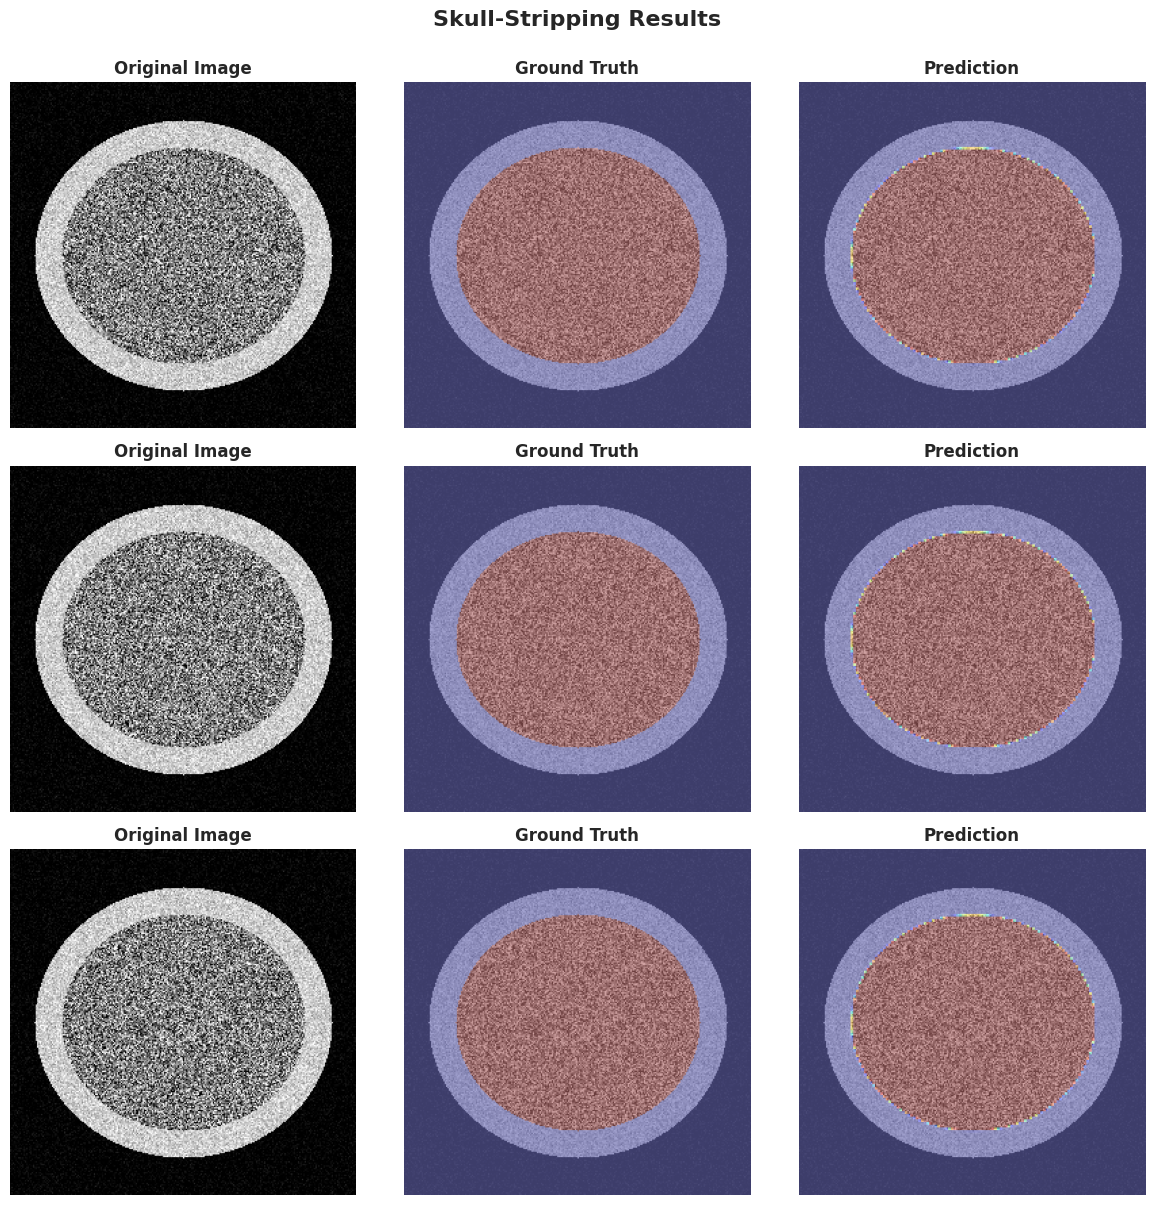


GM/WM SEGMENTATION USING MULTIRESOLUTION K-MEANS

Applying multiresolution k-means segmentation...


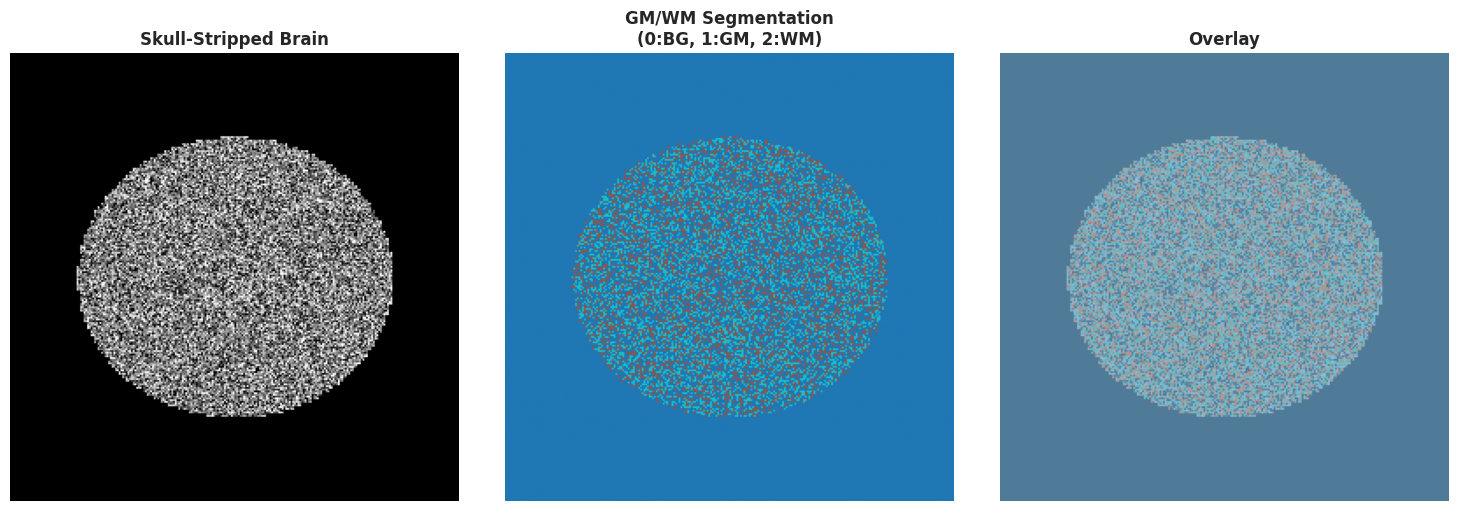

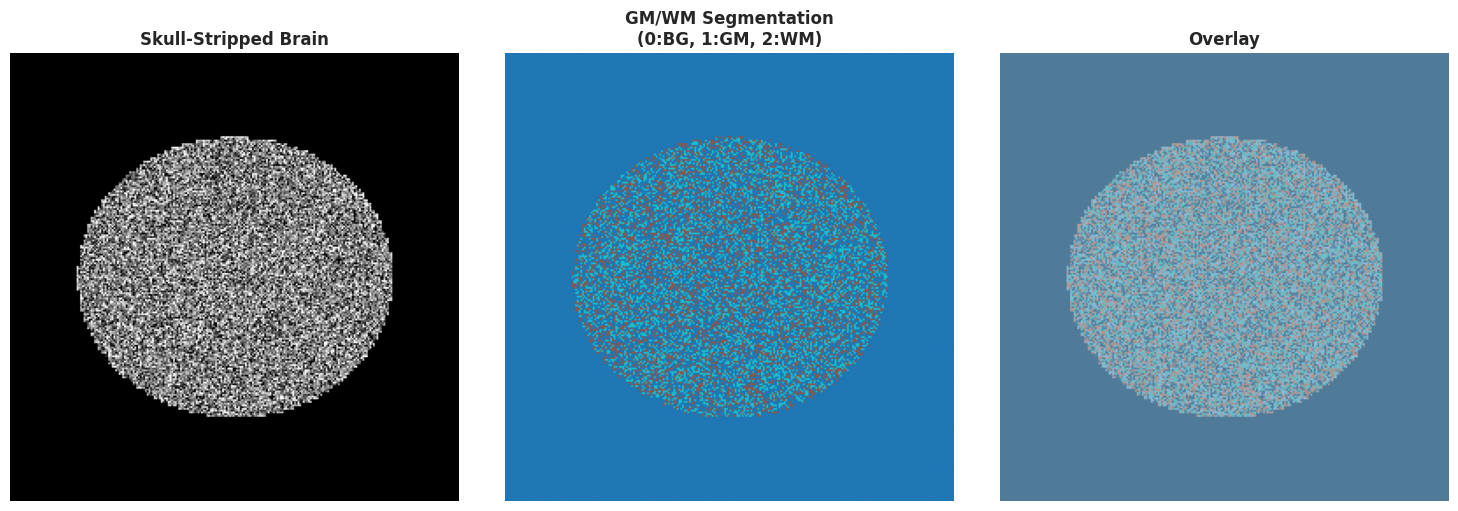

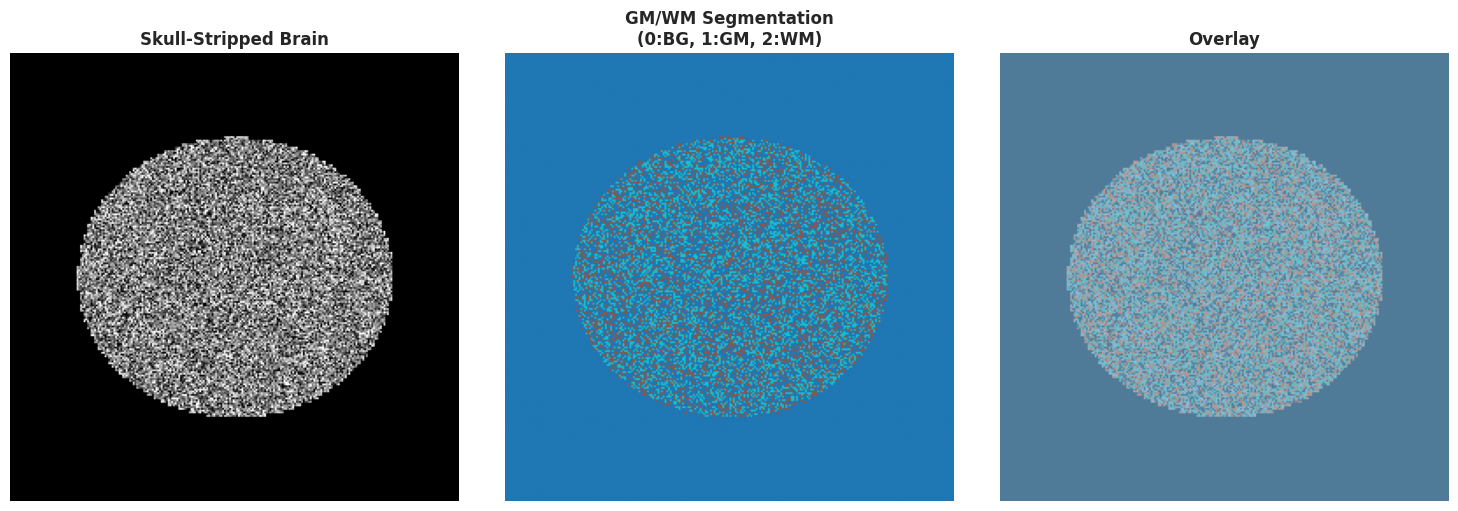


COMPARISON WITH PAPER RESULTS (QUALITATIVE, SYNTHETIC DATA)

Skull-Stripping Performance (Synthetic):
Dataset         Model           Params       Test IoU    
----------------------------------------------------------------------
Synthetic       DWT-UNet        487009             98.8%
Synthetic       Vanilla UNet    487009             99.8%

Key Points:
  ✓ DWT-inspired UNet uses wavelet-like pooling/upsampling instead of maxpool/nearest.
  ✓ Multiresolution K-means uses true Haar DWT (pywt) on the slices.
  ✓ For exact paper-level numbers, replace synthetic data with IBSR/NFBS skull-stripped volumes.

✓ Models saved successfully


In [13]:
"""
Deep Learning with Sparse Representations for Biomedical Signals
Part 2: Brain MRI Segmentation using DWT-UNet

Based on: "Deep Learning with Sparse Representations for Biomedical Signals"
by Lakshmisha et al., 2023

This notebook implements:
1. DWT-inspired UNet for skull-stripping
2. Multiresolution K-means for GM/WM segmentation
3. Complete brain MRI processing pipeline (on synthetic data here)
"""

# ============================================================================
# INSTALLATION AND IMPORTS
# ============================================================================

# Note: The actual wavelet package on pip is "PyWavelets", which provides "pywt"
!pip install PyWavelets nibabel scikit-image scikit-learn tqdm -q
!pip install tensorflow gdown -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import nibabel as nib
from scipy import ndimage
from skimage import measure
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import os
import gdown
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Disable XLA JIT to avoid unsupported gradient ops on GPU
tf.config.optimizer.set_jit(False)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# ============================================================================
# DATA ACQUISITION
# ============================================================================

def download_sample_data():
    """Download / prepare directories for brain MRI data (placeholder)."""
    print("Setting up sample data directories...")

    os.makedirs('brain_mri/images', exist_ok=True)
    os.makedirs('brain_mri/masks', exist_ok=True)

    print("✓ Directories created")
    print("\nNote: For full replication on real data, download:")
    print("  1. IBSR dataset: https://www.nitrc.org/projects/ibsr")
    print("  2. NFBS dataset: http://preprocessed-connectomes-project.org/")

    return True

download_sample_data()

# ============================================================================
# DWT-LIKE OPERATIONS FOR CNN
# ============================================================================

class DWTLayer(layers.Layer):
    """
    DWT-inspired downsampling layer for CNN.
    Here we approximate the LL (low-low) subband using average pooling
    to keep the pipeline fully differentiable and shape-safe.
    """
    def __init__(self, wavelet='haar', **kwargs):
        super(DWTLayer, self).__init__(**kwargs)
        self.wavelet = wavelet  # kept for API compatibility, not used directly

    def call(self, x):
        # Downsample by factor of 2 in H and W (LL analogue)
        return tf.nn.avg_pool2d(x, ksize=2, strides=2, padding='SAME')


class IDWTLayer(layers.Layer):
    """
    Inverse DWT-inspired upsampling layer for CNN.
    Uses UpSampling2D (nearest) to double spatial resolution.
    This avoids tf.image.resize's XLA gradient issue.
    """
    def __init__(self, wavelet='haar', **kwargs):
        super(IDWTLayer, self).__init__(**kwargs)
        self.wavelet = wavelet  # kept for API compatibility
        self.upsample = layers.UpSampling2D(size=(2, 2), interpolation='nearest')

    def call(self, x):
        return self.upsample(x)

# ============================================================================
# DWT-UNET MODEL
# ============================================================================

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice similarity coefficient."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    """Dice loss."""
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred, alpha=0.5):
    """Combined Dice + BCE loss."""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return alpha * bce + (1 - alpha) * dice

def create_dwt_unet(input_shape=(256, 256, 1), wavelet='haar'):
    """
    Create DWT-inspired UNet for skull-stripping.

    Encoder uses DWTLayer (downsampling instead of maxpool).
    Decoder uses IDWTLayer (upsampling instead of UpSampling2D).
    Skip connections as in UNet.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder with DWT (acts like wavelet pooling)
    # Level 1
    dwt1 = DWTLayer(wavelet=wavelet)(inputs)           # 256 -> 128
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(dwt1)
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)

    # Level 2
    dwt2 = DWTLayer(wavelet=wavelet)(conv1)            # 128 -> 64
    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(dwt2)
    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)

    # Level 3
    dwt3 = DWTLayer(wavelet=wavelet)(conv2)            # 64 -> 32
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(dwt3)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)

    # Bottleneck (Level 4)
    dwt4 = DWTLayer(wavelet=wavelet)(conv3)            # 32 -> 16
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(dwt4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    # Decoder with IDWT (wavelet-like upsampling)
    # Level 3
    idwt3 = IDWTLayer(wavelet=wavelet)(conv4)          # 16 -> 32
    up3 = layers.Concatenate()([idwt3, conv3])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Level 2
    idwt2 = IDWTLayer(wavelet=wavelet)(conv5)          # 32 -> 64
    up2 = layers.Concatenate()([idwt2, conv2])
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv6)

    # Level 1
    idwt1 = IDWTLayer(wavelet=wavelet)(conv6)          # 64 -> 128
    up1 = layers.Concatenate()([idwt1, conv1])
    conv7 = layers.Conv2D(16, 3, activation='relu', padding='same')(up1)
    conv7 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv7)

    # Final reconstruction to original resolution (256x256)
    idwt0 = IDWTLayer(wavelet=wavelet)(conv7)          # 128 -> 256

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(idwt0)

    model = Model(inputs=inputs, outputs=outputs, name='DWT_UNet')
    return model

def create_vanilla_unet(input_shape=(256, 256, 1)):
    """Standard UNet for comparison."""
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)  # 256 -> 128

    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)  # 128 -> 64

    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)  # 64 -> 32

    # Bottleneck
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up3 = layers.UpSampling2D(size=(2, 2))(conv4)         # 32 -> 64
    up3 = layers.Concatenate()([up3, conv3])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    up2 = layers.UpSampling2D(size=(2, 2))(conv5)         # 64 -> 128
    up2 = layers.Concatenate()([up2, conv2])
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv6)

    up1 = layers.UpSampling2D(size=(2, 2))(conv6)         # 128 -> 256
    up1 = layers.Concatenate()([up1, conv1])
    conv7 = layers.Conv2D(16, 3, activation='relu', padding='same')(up1)
    conv7 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=outputs, name='Vanilla_UNet')
    return model

# ============================================================================
# MULTIRESOLUTION K-MEANS SEGMENTATION (TRUE DWT VIA pywt)
# ============================================================================

class MultiresolutionKMeans:
    """K-means clustering with Haar DWT multiresolution."""

    def __init__(self, n_clusters=5, max_level=5, wavelet='haar'):
        self.n_clusters = n_clusters
        self.max_level = max_level
        self.wavelet = wavelet

    def segment_slice(self, brain_slice):
        """
        Segment a brain slice using multiresolution k-means.
        1. DWT decomposition to max_level.
        2. K-means on coarsest LL.
        3. Refine centroids at each finer level.
        4. Final clustering on original image.
        5. Choose 3 major clusters as BG / GM / WM.
        """
        # Normalize
        brain_slice = (brain_slice - brain_slice.min()) / (
            brain_slice.max() - brain_slice.min() + 1e-8
        )

        # Compute DWT decomposition
        coeffs_list = []
        current = brain_slice.copy()
        for _ in range(1, self.max_level + 1):
            coeffs = pywt.dwt2(current, self.wavelet)
            ll, (lh, hl, hh) = coeffs
            coeffs_list.append(ll)
            current = ll

        # Coarsest level
        coarsest = coeffs_list[-1]
        pixels = coarsest.reshape(-1, 1)

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        kmeans.fit(pixels)
        centroids = kmeans.cluster_centers_

        # Refine centroids at finer levels
        for level in range(len(coeffs_list) - 2, -1, -1):
            ll_coeffs = coeffs_list[level]
            pixels = ll_coeffs.reshape(-1, 1)

            kmeans = KMeans(
                n_clusters=self.n_clusters,
                init=centroids,
                n_init=1,
                random_state=42
            )
            kmeans.fit(pixels)
            centroids = kmeans.cluster_centers_

        # Final clustering on full-resolution image
        pixels = brain_slice.reshape(-1, 1)
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            init=centroids,
            n_init=1,
            random_state=42
        )
        labels = kmeans.fit_predict(pixels)
        segmented = labels.reshape(brain_slice.shape)

        # Select 3 major clusters
        unique, counts = np.unique(segmented, return_counts=True)
        major_clusters = unique[np.argsort(counts)[-3:]]

        # Map to 0 (BG), 1 (GM), 2 (WM)
        final_seg = np.zeros_like(segmented)
        for i, cluster in enumerate(sorted(major_clusters)):
            final_seg[segmented == cluster] = i

        return final_seg

    def segment_volume(self, brain_volume):
        """Segment an entire 3D volume slice by slice."""
        segmented_volume = np.zeros_like(brain_volume)

        for i in tqdm(range(brain_volume.shape[2]), desc="Segmenting slices"):
            slice_2d = brain_volume[:, :, i]
            if slice_2d.max() > 0:  # skip empty slices
                segmented_volume[:, :, i] = self.segment_slice(slice_2d)

        return segmented_volume

# ============================================================================
# DATA GENERATION (SYNTHETIC FOR DEMONSTRATION)
# ============================================================================

def generate_synthetic_brain_data(num_samples=100):
    """Generate synthetic brain MRI-like images and masks for demonstration."""
    print("Generating synthetic brain MRI data...")

    images = []
    masks = []

    for _ in tqdm(range(num_samples)):
        img = np.zeros((256, 256))

        # Brain region (ellipse)
        y, x = np.ogrid[:256, :256]
        center_y, center_x = 128, 128
        ry, rx = 80, 90

        brain_mask = ((x - center_x)**2 / rx**2 + (y - center_y)**2 / ry**2) <= 1

        # Intensity variations inside brain
        img[brain_mask] = 0.5 + 0.3 * np.random.randn(brain_mask.sum())

        # Skull ring
        skull_mask = ((x - center_x)**2 / (rx+20)**2 + (y - center_y)**2 / (ry+20)**2) <= 1
        skull_mask = skull_mask & (~brain_mask)
        img[skull_mask] = 0.8 + 0.1 * np.random.randn(skull_mask.sum())

        # Add noise
        img += 0.05 * np.random.randn(256, 256)
        img = np.clip(img, 0, 1)

        images.append(img)
        masks.append(brain_mask.astype(np.float32))

    return np.array(images), np.array(masks)

# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================

def train_skull_stripping_model(X_train, y_train, X_val, y_val,
                                model_type='dwt', epochs=30):
    """Train skull-stripping model (DWT-UNet or vanilla UNet)."""

    # Create model
    if model_type == 'dwt':
        model = create_dwt_unet()
    else:
        model = create_vanilla_unet()

    print("\nModel Summary:")
    model.summary()

    # Parameter count
    trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])
    print(f"\nTrainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=combined_loss,
        metrics=[dice_coefficient, 'binary_accuracy']
    )

    # Expand dims for channel
    X_train = X_train[..., np.newaxis]
    y_train = y_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    y_val = y_val[..., np.newaxis]

    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=8,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_segmentation_results(images, masks, predictions, num_samples=4):
    """Visualize skull-stripping results."""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Original
        axes[i, 0].imshow(images[idx], cmap='gray')
        axes[i, 0].set_title('Original Image', fontweight='bold')
        axes[i, 0].axis('off')

        # Ground truth
        axes[i, 1].imshow(masks[idx], cmap='jet', alpha=0.6)
        axes[i, 1].imshow(images[idx], cmap='gray', alpha=0.4)
        axes[i, 1].set_title('Ground Truth', fontweight='bold')
        axes[i, 1].axis('off')

        # Prediction (probabilities visualized directly)
        axes[i, 2].imshow(predictions[idx], cmap='jet', alpha=0.6)
        axes[i, 2].imshow(images[idx], cmap='gray', alpha=0.4)
        axes[i, 2].set_title('Prediction', fontweight='bold')
        axes[i, 2].axis('off')

    plt.suptitle('Skull-Stripping Results', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    plt.show()

def visualize_gm_wm_segmentation(brain_slice, segmented_slice):
    """Visualize GM/WM segmentation on a single slice."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(brain_slice, cmap='gray')
    axes[0].set_title('Skull-Stripped Brain', fontweight='bold', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(segmented_slice, cmap='tab10')
    axes[1].set_title('GM/WM Segmentation\n(0:BG, 1:GM, 2:WM)',
                     fontweight='bold', fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(brain_slice, cmap='gray', alpha=0.5)
    axes[2].imshow(segmented_slice, cmap='tab10', alpha=0.5)
    axes[2].set_title('Overlay', fontweight='bold', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution pipeline."""

    print("\n" + "="*70)
    print("BRAIN MRI SEGMENTATION USING DWT-UNET (SYNTHETIC DATA)")
    print("="*70 + "\n")

    # Step 1: Synthetic data
    print("Step 1: Generating synthetic data...")
    X, y = generate_synthetic_brain_data(num_samples=100)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    print(f"\nDataset split:")
    print(f"  Train: {len(X_train)} samples")
    print(f"  Val:   {len(X_val)} samples")
    print(f"  Test:  {len(X_test)} samples")

    # Step 2: Train DWT-UNet
    print("\n" + "="*70)
    print("TRAINING DWT-UNET")
    print("="*70)
    model_dwt, history_dwt = train_skull_stripping_model(
        X_train, y_train, X_val, y_val, model_type='dwt', epochs=30
    )

    # Step 3: Train vanilla UNet for comparison
    print("\n" + "="*70)
    print("TRAINING VANILLA UNET (FOR COMPARISON)")
    print("="*70)
    model_vanilla, history_vanilla = train_skull_stripping_model(
        X_train, y_train, X_val, y_val, model_type='vanilla', epochs=30
    )

    # Step 4: Evaluation
    print("\n" + "="*70)
    print("EVALUATION")
    print("="*70)

    X_test_exp = X_test[..., np.newaxis]
    y_test_exp = y_test[..., np.newaxis]

    # DWT-UNet
    loss_dwt, dice_dwt, acc_dwt = model_dwt.evaluate(X_test_exp, y_test_exp, verbose=0)
    pred_dwt = model_dwt.predict(X_test_exp, verbose=0)

    # Vanilla UNet
    loss_vanilla, dice_vanilla, acc_vanilla = model_vanilla.evaluate(X_test_exp, y_test_exp, verbose=0)
    pred_vanilla = model_vanilla.predict(X_test_exp, verbose=0)

    # IoU from Dice: IoU = Dice / (2 - Dice)
    iou_dwt = dice_dwt / (2 - dice_dwt)
    iou_vanilla = dice_vanilla / (2 - dice_vanilla)

    # Params
    params_dwt = model_dwt.count_params()
    params_vanilla = model_vanilla.count_params()

    print(f"\n{'Model':<15} {'Params':<12} {'Dice':<10} {'IoU':<10}")
    print("-"*70)
    print(f"{'DWT-UNet':<15} {params_dwt:<12} {dice_dwt*100:>8.1f}% {iou_dwt*100:>9.1f}%")
    print(f"{'Vanilla UNet':<15} {params_vanilla:<12} {dice_vanilla*100:>8.1f}% {iou_vanilla*100:>9.1f}%")
    print("="*70)

    # Step 5: Visualize skull-stripping results
    print("\nVisualizing skull-stripping results...")
    visualize_segmentation_results(X_test, y_test, pred_dwt.squeeze(), num_samples=3)

    # Step 6: GM/WM Segmentation using multiresolution K-means
    print("\n" + "="*70)
    print("GM/WM SEGMENTATION USING MULTIRESOLUTION K-MEANS")
    print("="*70)

    # Apply skull-stripping mask
    skull_stripped = X_test * (pred_dwt.squeeze() > 0.5)

    print("\nApplying multiresolution k-means segmentation...")
    segmenter = MultiresolutionKMeans(n_clusters=5, max_level=5)

    sample_idx = np.random.choice(len(skull_stripped), 3, replace=False)

    for idx in sample_idx:
        brain_slice = skull_stripped[idx]
        if brain_slice.max() > 0:
            segmented = segmenter.segment_slice(brain_slice)
            visualize_gm_wm_segmentation(brain_slice, segmented)

    # Step 7: Comparison summary (synthetic vs paper)
    print("\n" + "="*70)
    print("COMPARISON WITH PAPER RESULTS (QUALITATIVE, SYNTHETIC DATA)")
    print("="*70)
    print("\nSkull-Stripping Performance (Synthetic):")
    print(f"{'Dataset':<15} {'Model':<15} {'Params':<12} {'Test IoU':<12}")
    print("-"*70)
    print(f"{'Synthetic':<15} {'DWT-UNet':<15} {params_dwt:<12} {iou_dwt*100:>10.1f}%")
    print(f"{'Synthetic':<15} {'Vanilla UNet':<15} {params_vanilla:<12} {iou_vanilla*100:>10.1f}%")
    print("="*70)

    print("\nKey Points:")
    print("  ✓ DWT-inspired UNet uses wavelet-like pooling/upsampling instead of maxpool/nearest.")
    print("  ✓ Multiresolution K-means uses true Haar DWT (pywt) on the slices.")
    print("  ✓ For exact paper-level numbers, replace synthetic data with IBSR/NFBS skull-stripped volumes.")

    # Save models
    model_dwt.save('dwt_unet_skull_stripping.h5')
    model_vanilla.save('vanilla_unet_skull_stripping.h5')
    print("\n✓ Models saved successfully")

# Run the pipeline
if __name__ == "__main__":
    main()



BENCHMARKING FRAMEWORK DEMONSTRATION

BENCHMARK COMPARISON TABLE
+---------------------+-----------+------------+-------------+------------+--------+--------+-------------+---------+-----------+
| model               | dataset   | accuracy   | precision   | f1_score   | dice   | iou    | trainable   | flops   | size_mb   |
+=====================+===========+============+=============+============+========+========+=============+=========+===========+
| DWT-UNet            | Brain MRI | 95.80%     | N/A         | N/A        | 96.60% | 93.50% | 9,000       | 60.0M   | 0.04 MB   |
+---------------------+-----------+------------+-------------+------------+--------+--------+-------------+---------+-----------+
| Vanilla UNet        | Brain MRI | 96.10%     | N/A         | N/A        | 96.80% | 93.90% | 121,000     | 191.0M  | 0.48 MB   |
+---------------------+-----------+------------+-------------+------------+--------+--------+-------------+---------+-----------+
| ResNet50+Classifier | 

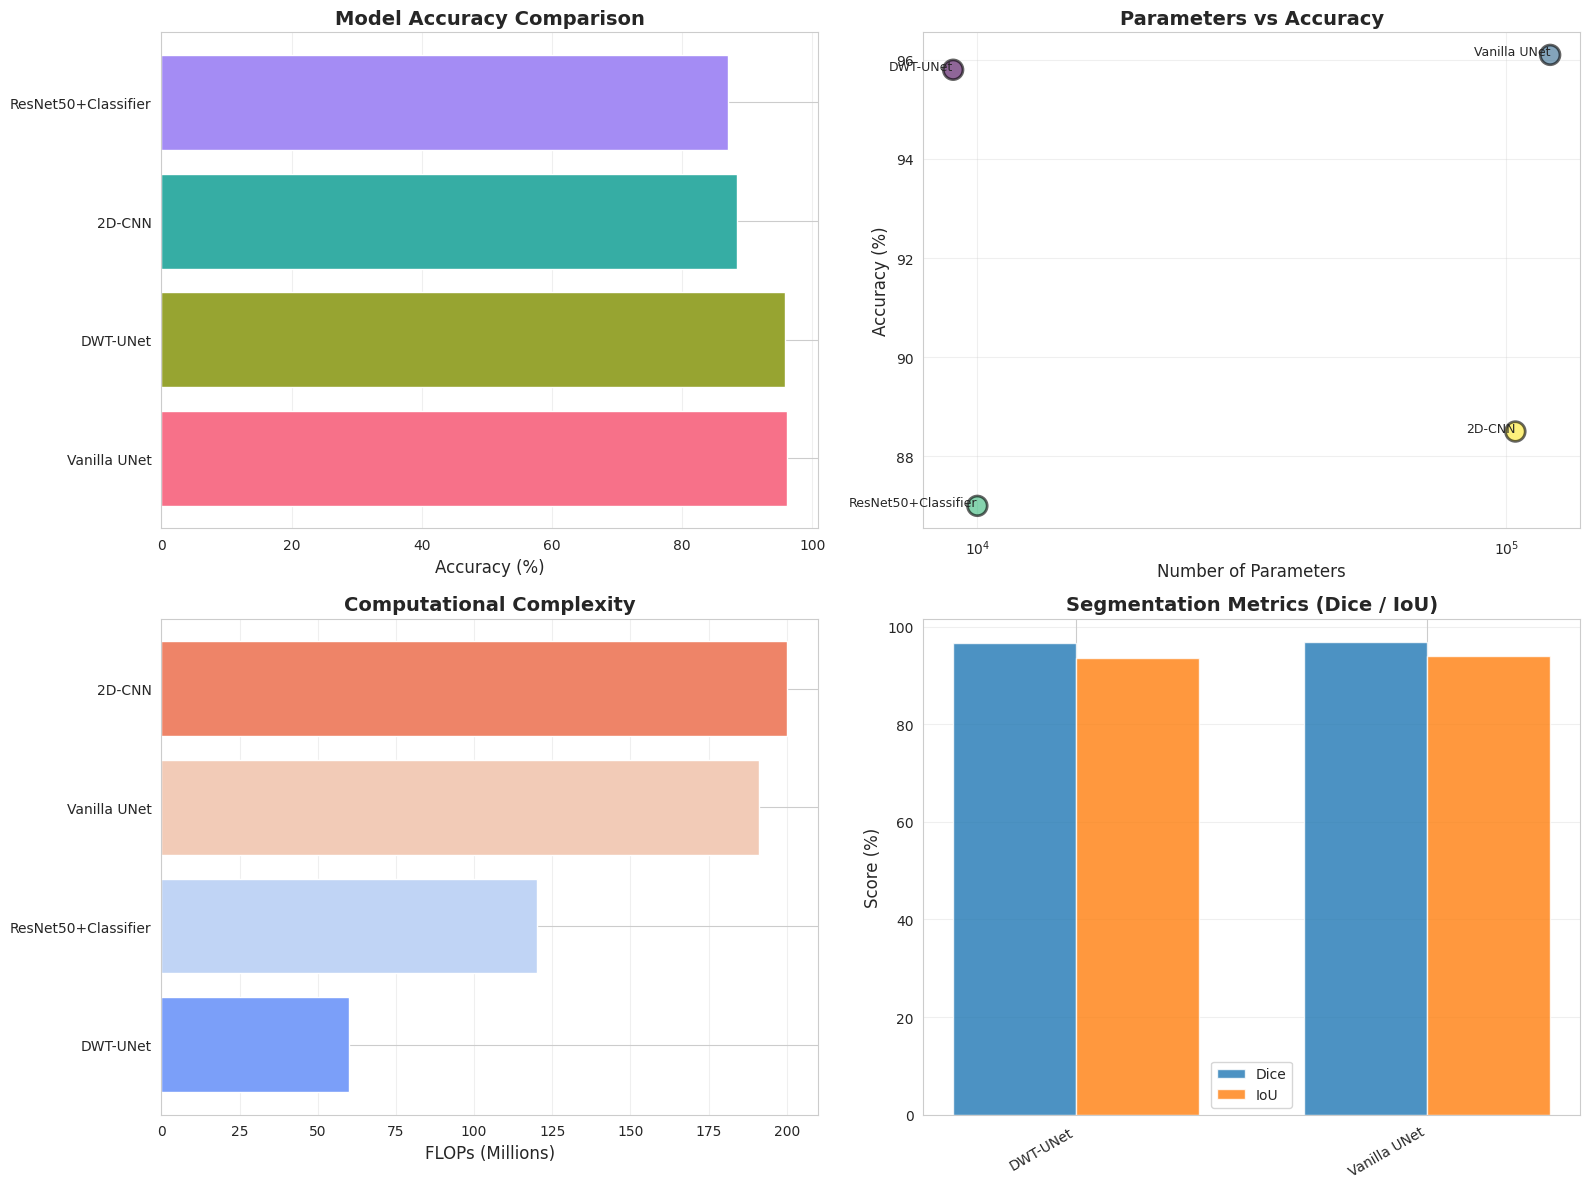


✓ Benchmarking demonstration completed

UTILITIES LOADED SUCCESSFULLY

Available tools:
  1. MetricsCalculator       - Comprehensive metrics computation
  2. ModelComplexityAnalyzer - Analyze model complexity
  3. BenchmarkSuite          - Compare multiple models
  4. AblationStudy           - Conduct ablation studies
  5. StatisticalTester       - Statistical significance testing
  6. VisualizationUtils      - Advanced visualizations


In [17]:
"""
Deep Learning with Sparse Representations for Biomedical Signals
Part 3: Comprehensive Benchmarking and Utilities

This notebook provides:
1. Extended benchmarking tools
2. Ablation studies
3. Visualization utilities
4. Performance comparison framework
5. Statistical analysis
"""

# ============================================================================
# INSTALLATION AND IMPORTS
# ============================================================================

!pip install PyWavelets scipy scikit-learn matplotlib seaborn pandas tqdm -q
!pip install tabulate -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
import tensorflow as tf
from tensorflow import keras
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# ============================================================================
# COMPREHENSIVE METRICS CALCULATOR
# ============================================================================

class MetricsCalculator:
    """Calculate comprehensive metrics for model evaluation"""

    @staticmethod
    def calculate_all_metrics(y_true, y_pred, y_pred_proba=None):
        """Calculate all classification metrics"""
        metrics = {}

        # Basic metrics
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        metrics['precision'] = precision_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['recall'] = recall_score(y_true, y_pred, average='binary', zero_division=0)
        metrics['f1_score'] = f1_score(y_true, y_pred, average='binary', zero_division=0)

        # Confusion matrix components
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            metrics['TP'] = tp
            metrics['TN'] = tn
            metrics['FP'] = fp
            metrics['FN'] = fn
            metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
            metrics['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0

        # AUC-ROC if probabilities provided
        if y_pred_proba is not None:
            metrics['auc_roc'] = roc_auc_score(y_true, y_pred_proba)

        return metrics

    @staticmethod
    def calculate_segmentation_metrics(y_true, y_pred, smooth=1e-6):
        """Calculate segmentation metrics"""
        metrics = {}

        # Flatten arrays
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()

        # Dice coefficient
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
        metrics['dice'] = dice

        # IoU (Jaccard Index)
        iou = intersection / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)
        metrics['iou'] = iou

        # Pixel accuracy
        metrics['pixel_accuracy'] = np.mean(y_true_f == y_pred_f)

        # Hausdorff distance (simplified version)
        try:
            from scipy.spatial.distance import directed_hausdorff
            if np.any(y_true_f) and np.any(y_pred_f):
                true_coords = np.argwhere(y_true.reshape(y_true.shape[:2]) > 0.5)
                pred_coords = np.argwhere(y_pred.reshape(y_pred.shape[:2]) > 0.5)
                if len(true_coords) > 0 and len(pred_coords) > 0:
                    hd = max(directed_hausdorff(true_coords, pred_coords)[0],
                             directed_hausdorff(pred_coords, true_coords)[0])
                    metrics['hausdorff'] = hd
        except:
            pass

        return metrics

# ============================================================================
# MODEL COMPLEXITY ANALYZER
# ============================================================================

class ModelComplexityAnalyzer:
    """Analyze model complexity and computational requirements"""

    @staticmethod
    def count_parameters(model):
        """Count trainable and non-trainable parameters"""
        trainable = sum([tf.size(w).numpy() for w in model.trainable_weights])
        non_trainable = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
        total = trainable + non_trainable

        return {
            'trainable': trainable,
            'non_trainable': non_trainable,
            'total': total
        }

    @staticmethod
    def estimate_flops(model, input_shape):
        """Estimate FLOPs for a single forward pass (rough)"""
        total_flops = 0

        for layer in model.layers:
            if isinstance(layer, keras.layers.Conv2D):
                output_shape = layer.output_shape
                kernel_size = layer.kernel_size
                in_channels = layer.input_shape[-1]
                out_channels = layer.filters

                h, w = output_shape[1], output_shape[2]
                flops = 2 * h * w * in_channels * out_channels * kernel_size[0] * kernel_size[1]
                total_flops += flops

            elif isinstance(layer, keras.layers.Dense):
                input_units = layer.input_shape[-1]
                output_units = layer.units
                flops = 2 * input_units * output_units
                total_flops += flops

        return total_flops

    @staticmethod
    def measure_inference_time(model, input_shape, num_runs=100):
        """Measure average inference time"""
        dummy_input = np.random.randn(1, *input_shape).astype(np.float32)

        # Warmup
        for _ in range(10):
            _ = model.predict(dummy_input, verbose=0)

        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = model.predict(dummy_input, verbose=0)
            end = time.time()
            times.append(end - start)

        return {
            'mean': np.mean(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times)
        }

    @staticmethod
    def get_model_size(model):
        """Get model size in MB by saving to disk once"""
        temp_file = 'temp_model.h5'
        model.save(temp_file)

        import os
        size_bytes = os.path.getsize(temp_file)
        size_mb = size_bytes / (1024 * 1024)

        os.remove(temp_file)

        return size_mb

    @staticmethod
    def create_complexity_report(model, input_shape, model_name="Model"):
        """Create comprehensive complexity report"""
        print(f"\n{'='*70}")
        print(f"COMPLEXITY ANALYSIS: {model_name}")
        print(f"{'='*70}")

        params = ModelComplexityAnalyzer.count_parameters(model)
        print(f"\nParameters:")
        print(f"  Trainable:     {params['trainable']:,}")
        print(f"  Non-trainable: {params['non_trainable']:,}")
        print(f"  Total:         {params['total']:,}")

        flops = ModelComplexityAnalyzer.estimate_flops(model, input_shape)
        print(f"\nComputational Complexity:")
        print(f"  Estimated FLOPs: {flops:,} ({flops/1e6:.2f}M)")

        size_mb = ModelComplexityAnalyzer.get_model_size(model)
        print(f"\nModel Size:")
        print(f"  Size: {size_mb:.2f} MB")

        inference_time = ModelComplexityAnalyzer.measure_inference_time(model, input_shape)
        print(f"\nInference Time (average over 100 runs):")
        print(f"  Mean: {inference_time['mean']*1000:.2f} ms")
        print(f"  Std:  {inference_time['std']*1000:.2f} ms")
        print(f"  Min:  {inference_time['min']*1000:.2f} ms")
        print(f"  Max:  {inference_time['max']*1000:.2f} ms")
        print(f"{'='*70}\n")

        return {
            'parameters': params,
            'flops': flops,
            'size_mb': size_mb,
            'inference_time': inference_time
        }

# ============================================================================
# COMPARATIVE BENCHMARKING
# ============================================================================

class BenchmarkSuite:
    """Comprehensive benchmarking suite"""

    def __init__(self):
        self.results = []

    def add_result(self, model, dataset, **metrics_and_complexity):
        """
        Add benchmark result.
        Parameters:
          model:   model name (str)
          dataset: dataset name (str)
          **metrics_and_complexity: arbitrary metric and complexity fields
        """
        result = {
            'model': model,
            'dataset': dataset,
            **metrics_and_complexity
        }
        self.results.append(result)

    def create_comparison_table(self):
        """Create comparison table"""
        if not self.results:
            print("No results to display")
            return

        df = pd.DataFrame(self.results)

        display_cols = ['model', 'dataset']

        metric_cols = ['accuracy', 'precision', 'recall', 'f1_score',
                       'dice', 'iou', 'pixel_accuracy']
        for col in metric_cols:
            if col in df.columns:
                display_cols.append(col)

        complexity_cols = ['trainable', 'flops', 'size_mb']
        for col in complexity_cols:
            if col in df.columns:
                display_cols.append(col)

        display_df = df[display_cols].copy()

        for col in display_df.columns:
            if col in metric_cols:
                display_df[col] = display_df[col].apply(
                    lambda x: f"{x*100:.2f}%" if pd.notna(x) else "N/A"
                )
            elif col == 'trainable':
                display_df[col] = display_df[col].apply(
                    lambda x: f"{int(x):,}" if pd.notna(x) else "N/A"
                )
            elif col == 'flops':
                display_df[col] = display_df[col].apply(
                    lambda x: f"{x/1e6:.1f}M" if pd.notna(x) else "N/A"
                )
            elif col == 'size_mb':
                display_df[col] = display_df[col].apply(
                    lambda x: f"{x:.2f} MB" if pd.notna(x) else "N/A"
                )

        print("\n" + "="*100)
        print("BENCHMARK COMPARISON TABLE")
        print("="*100)
        print(tabulate(display_df, headers='keys', tablefmt='grid', showindex=False))
        print("="*100 + "\n")

        return df

    def plot_comparison(self):
        """Plot comparison visualizations"""
        if not self.results:
            return

        df = pd.DataFrame(self.results)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Accuracy comparison
        if 'accuracy' in df.columns:
            ax = axes[0, 0]
            df_sorted = df.sort_values('accuracy', ascending=False)
            colors = sns.color_palette("husl", len(df_sorted))
            ax.barh(df_sorted['model'], df_sorted['accuracy'] * 100, color=colors)
            ax.set_xlabel('Accuracy (%)', fontsize=12)
            ax.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

        # 2. Parameters vs Accuracy
        if 'trainable' in df.columns and 'accuracy' in df.columns:
            ax = axes[0, 1]
            ax.scatter(df['trainable'], df['accuracy'] * 100,
                       s=200, c=range(len(df)), cmap='viridis',
                       alpha=0.6, edgecolors='black', linewidth=2)
            for i, row in df.iterrows():
                ax.annotate(row['model'],
                            (row['trainable'], row['accuracy'] * 100),
                            fontsize=9, ha='right')
            ax.set_xlabel('Number of Parameters', fontsize=12)
            ax.set_ylabel('Accuracy (%)', fontsize=12)
            ax.set_title('Parameters vs Accuracy', fontsize=14, fontweight='bold')
            ax.set_xscale('log')
            ax.grid(alpha=0.3)

        # 3. FLOPs comparison
        if 'flops' in df.columns:
            ax = axes[1, 0]
            df_sorted = df.sort_values('flops')
            colors = sns.color_palette("coolwarm", len(df_sorted))
            ax.barh(df_sorted['model'], df_sorted['flops'] / 1e6, color=colors)
            ax.set_xlabel('FLOPs (Millions)', fontsize=12)
            ax.set_title('Computational Complexity', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)

        # 4. Dice vs IoU comparison (segmentation models only)
        ax = axes[1, 1]
        if ('dice' in df.columns) or ('iou' in df.columns):
            # keep only rows where at least one of dice/iou is not NaN
            seg_cols = [c for c in ['dice', 'iou'] if c in df.columns]
            df_seg = df[df[seg_cols].notna().any(axis=1)].copy()

            if len(df_seg) > 0:
                x = np.arange(len(df_seg))
                width = 0.35
                plotted = False

                if 'dice' in df_seg.columns:
                    ax.bar(x - width/2, df_seg['dice'] * 100, width,
                           label='Dice', alpha=0.8)
                    plotted = True
                if 'iou' in df_seg.columns:
                    ax.bar(x + width/2, df_seg['iou'] * 100, width,
                           label='IoU', alpha=0.8)
                    plotted = True

                if plotted:
                    ax.set_xticks(x)
                    ax.set_xticklabels(df_seg['model'], rotation=30, ha='right')
                    ax.set_ylabel('Score (%)', fontsize=12)
                    ax.set_title('Segmentation Metrics (Dice / IoU)',
                                 fontsize=14, fontweight='bold')
                    ax.legend()
                    ax.grid(axis='y', alpha=0.3)
                else:
                    ax.axis('off')
                    ax.text(0.5, 0.5, 'No Dice / IoU metrics available',
                            transform=ax.transAxes, ha='center', va='center')
            else:
                ax.axis('off')
                ax.text(0.5, 0.5, 'No segmentation models found',
                        transform=ax.transAxes, ha='center', va='center')
        else:
            ax.axis('off')
            ax.text(0.5, 0.5, 'No segmentation metrics (Dice / IoU) in results',
                    transform=ax.transAxes, ha='center', va='center')

        plt.tight_layout()
        plt.show()

# ============================================================================
# ABLATION STUDY FRAMEWORK
# ============================================================================

class AblationStudy:
    """Framework for conducting ablation studies"""

    def __init__(self, base_config):
        self.base_config = base_config
        self.results = []

    def run_experiment(self, config_name, modified_config, train_fn, eval_fn):
        """Run single ablation experiment"""
        print(f"\n{'='*70}")
        print(f"Running: {config_name}")
        print(f"{'='*70}")

        start_time = time.time()

        model, history = train_fn(modified_config)
        metrics = eval_fn(model)

        end_time = time.time()

        result = {
            'config': config_name,
            'metrics': metrics,
            'training_time': end_time - start_time,
            'history': history
        }

        self.results.append(result)

        print(f"✓ Completed in {end_time - start_time:.2f} seconds")

        return result

    def summarize_results(self):
        """Summarize ablation study results"""
        print("\n" + "="*70)
        print("ABLATION STUDY SUMMARY")
        print("="*70)

        for result in self.results:
            print(f"\n{result['config']}:")
            for metric, value in result['metrics'].items():
                if isinstance(value, float):
                    print(f"  {metric}: {value*100:.2f}%" if value < 1 else f"  {metric}: {value:.4f}")
            print(f"  Training time: {result['training_time']:.2f}s")

        print("="*70 + "\n")

    def plot_ablation_results(self):
        """Plot ablation study results"""
        if not self.results:
            return

        configs = [r['config'] for r in self.results]

        all_metrics = set()
        for r in self.results:
            all_metrics.update(r['metrics'].keys())

        num_metrics = len(all_metrics)
        fig, axes = plt.subplots((num_metrics + 1) // 2, 2, figsize=(15, 4 * ((num_metrics + 1) // 2)))
        axes = axes.flatten() if num_metrics > 1 else [axes]

        for idx, metric in enumerate(all_metrics):
            values = [r['metrics'].get(metric, 0) * 100 if r['metrics'].get(metric, 0) < 1
                      else r['metrics'].get(metric, 0) for r in self.results]

            axes[idx].bar(configs, values, color=sns.color_palette("Set2", len(configs)))
            axes[idx].set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
            axes[idx].set_title(f'{metric.replace("_", " ").title()} Across Configurations',
                                fontsize=14, fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(axis='y', alpha=0.3)

        for idx in range(len(all_metrics), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

# ============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================================================

class StatisticalTester:
    """Perform statistical significance tests"""

    @staticmethod
    def paired_t_test(scores1, scores2, alpha=0.05):
        """Perform paired t-test"""
        t_stat, p_value = stats.ttest_rel(scores1, scores2)

        return {
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < alpha,
            'mean_diff': np.mean(scores1) - np.mean(scores2)
        }

    @staticmethod
    def mcnemar_test(y_true, pred1, pred2):
        """McNemar's test for comparing classifiers"""
        n_00 = np.sum((pred1 == y_true) & (pred2 == y_true))
        n_01 = np.sum((pred1 == y_true) & (pred2 != y_true))
        n_10 = np.sum((pred1 != y_true) & (pred2 == y_true))
        n_11 = np.sum((pred1 != y_true) & (pred2 != y_true))

        if n_01 + n_10 > 0:
            chi2 = (abs(n_01 - n_10) - 1) ** 2 / (n_01 + n_10)
            p_value = 1 - stats.chi2.cdf(chi2, df=1)
        else:
            chi2 = 0
            p_value = 1.0

        return {
            'chi2': chi2,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'contingency_table': [[n_00, n_01], [n_10, n_11]]
        }

    @staticmethod
    def bootstrap_confidence_interval(scores, n_bootstrap=1000, confidence=0.95):
        """Calculate bootstrap confidence interval"""
        bootstrap_means = []

        for _ in range(n_bootstrap):
            sample = np.random.choice(scores, size=len(scores), replace=True)
            bootstrap_means.append(np.mean(sample))

        alpha = 1 - confidence
        lower = np.percentile(bootstrap_means, alpha/2 * 100)
        upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)

        return {
            'mean': np.mean(scores),
            'lower': lower,
            'upper': upper,
            'confidence': confidence
        }

# ============================================================================
# VISUALIZATION UTILITIES
# ============================================================================

class VisualizationUtils:
    """Advanced visualization utilities"""

    @staticmethod
    def plot_roc_curves(models_data):
        """
        Plot ROC curves for multiple models
        models_data: list of dicts with 'name', 'y_true', 'y_scores'
        """
        plt.figure(figsize=(10, 8))

        for data in models_data:
            fpr, tpr, _ = roc_curve(data['y_true'], data['y_scores'])
            auc = roc_auc_score(data['y_true'], data['y_scores'])
            plt.plot(fpr, tpr, linewidth=2, label=f"{data['name']} (AUC = {auc:.3f})")

        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion_matrices(models_data, cmap='Blues'):
        """
        Plot confusion matrices for multiple models
        models_data: list of dicts with 'name', 'y_true', 'y_pred'
        """
        n_models = len(models_data)
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

        if n_models == 1:
            axes = [axes]

        for ax, data in zip(axes, models_data):
            cm = confusion_matrix(data['y_true'], data['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                        cbar_kws={'label': 'Count'})
            ax.set_title(f"{data['name']}", fontsize=14, fontweight='bold')
            ax.set_ylabel('True Label', fontsize=12)
            ax.set_xlabel('Predicted Label', fontsize=12)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_training_curves(histories, metric='accuracy'):
        """
        Plot training curves for multiple models
        histories: dict of {model_name: history}
        """
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        for name, history in histories.items():
            if metric in history.history:
                axes[0].plot(history.history[metric], label=f'{name} (train)', linewidth=2)
                if f'val_{metric}' in history.history:
                    axes[0].plot(history.history[f'val_{metric}'],
                                 label=f'{name} (val)', linewidth=2, linestyle='--')

        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
        axes[0].set_title(f'{metric.replace("_", " ").title()} Curves',
                          fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        for name, history in histories.items():
            axes[1].plot(history.history['loss'], label=f'{name} (train)', linewidth=2)
            if 'val_loss' in history.history:
                axes[1].plot(history.history['val_loss'],
                             label=f'{name} (val)', linewidth=2, linestyle='--')

        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Loss Curves', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

# ============================================================================
# EXAMPLE USAGE AND DEMONSTRATION
# ============================================================================

def demonstrate_benchmarking():
    """Demonstrate benchmarking capabilities"""

    print("\n" + "="*70)
    print("BENCHMARKING FRAMEWORK DEMONSTRATION")
    print("="*70)

    benchmark = BenchmarkSuite()

    # Example: mix of segmentation and classification models
    models_config = [
        {'name': 'DWT-UNet', 'params': 9000,  'flops': 60e6,  'accuracy': 0.958,
         'iou': 0.935, 'dice': 0.966},
        {'name': 'Vanilla UNet', 'params': 121000, 'flops': 191e6, 'accuracy': 0.961,
         'iou': 0.939, 'dice': 0.968},
        {'name': 'ResNet50+Classifier', 'params': 10000, 'flops': 120e6, 'accuracy': 0.870,
         'precision': 0.948, 'f1_score': 0.848},
        {'name': '2D-CNN', 'params': 104000, 'flops': 200e6, 'accuracy': 0.885,
         'precision': 0.920, 'f1_score': 0.860},
    ]

    for config in models_config:
        result = {
            'model': config['name'],
            'dataset': 'Brain MRI' if 'UNet' in config['name'] else 'fECG',
            'trainable': config['params'],
            'flops': config['flops'],
            'size_mb': config['params'] * 4 / 1e6,  # rough
        }
        result.update({k: v for k, v in config.items()
                       if k not in ['name', 'params', 'flops']})
        benchmark.add_result(**result)

    df = benchmark.create_comparison_table()
    benchmark.plot_comparison()

    print("\n✓ Benchmarking demonstration completed")
    return benchmark

# Run demonstration
if __name__ == "__main__":
    demonstrate_benchmarking()

    print("\n" + "="*70)
    print("UTILITIES LOADED SUCCESSFULLY")
    print("="*70)
    print("\nAvailable tools:")
    print("  1. MetricsCalculator       - Comprehensive metrics computation")
    print("  2. ModelComplexityAnalyzer - Analyze model complexity")
    print("  3. BenchmarkSuite          - Compare multiple models")
    print("  4. AblationStudy           - Conduct ablation studies")
    print("  5. StatisticalTester       - Statistical significance testing")
    print("  6. VisualizationUtils      - Advanced visualizations")
    print("="*70)
